In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
from skimage import measure
from scipy.ndimage import label
import umap
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

from tqdm import tqdm
import os

from src.models import SpaceNet, RecurrentSpaceNet, Decoder, LinearDecoder
from src.utils import ratemap_collage, SimpleDatasetMaker, get_ratemaps

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

In [2]:
figure_path = os.path.join(os.getcwd(), "figures")
model_path = os.path.join(os.getcwd(), "models")
results_path = os.path.join(os.getcwd(), "results")

## Different n

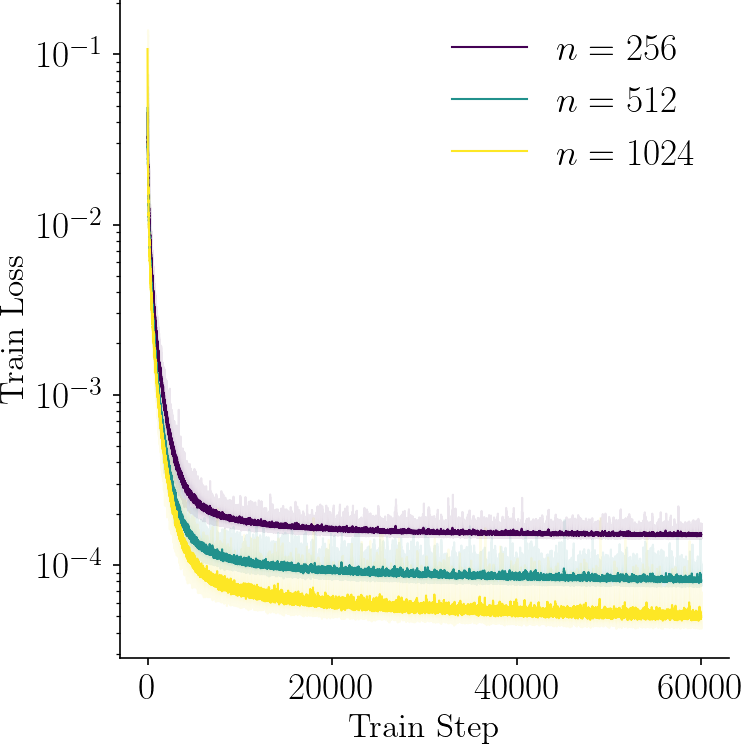

In [63]:
# Maps a model label to the corresponding model name as it is saved
model_name_map = {
    "256_ff": r"$n=256$",
    "512_ff": r"$n=512$",
    "1024_ff": r"$n=1024$",
}

# Load models and loss histories
models, loss_histories = {}, {}
for name, label in model_name_map.items():
    models[name] = [torch.load(os.path.join(model_path, f"{name}_{i}.pt")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}.pt"))]
    loss_histories[name] = [np.load(os.path.join(model_path, f"{name}_{i}_loss_history.npy")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}_loss_history.npy"))]

    # Remove if empty
    if len(models[name]) == 0:
        del models[name]
        del loss_histories[name]
        
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()
plt.show()

fig.savefig(os.path.join(figure_path, 'ff_training_loss_n_comparison.svg'), transparent=True)

## Other

In [64]:
# Maps a model label to the corresponding model name as it is saved
model_name_map = {
    
    "256_ff_01scale": r"$\sigma=0.1 \: \: \:  \beta=0.5 \: \: \:$",
    "256_ff": r"$\sigma=0.25 \: \beta=0.5$",
    "256_ff_05scale": r"$\sigma=0.5 \: \: \: \beta=0.5 \: \: \:$",
    
    "256_ff_01scale_0beta": r"$\sigma=0.1 \: \: \: \beta=0.0 \: \: \:$",
    "256_ff_0beta": r"$\sigma=0.25 \: \beta=0.0 \: \: \:$",
    "256_ff_05scale_0beta": r"$\sigma=0.5 \: \: \: \beta=0.0 \: \: \:$",
    
    # "256_ff_025beta": r"$\sigma=0.25 \: \beta=0.25$",
    # "256_ff_075beta": r"$\sigma=0.25 \: \beta=0.75$",   
}

# Load models and loss histories
models, loss_histories = {}, {}
for name in model_name_map.keys():
    models[name] = [torch.load(os.path.join(model_path, f"{name}_{i}.pt")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}.pt"))]
    loss_histories[name] = [np.load(os.path.join(model_path, f"{name}_{i}_loss_history.npy")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}_loss_history.npy"))]

    # Remove if empty
    if len(models[name]) == 0:
        del models[name]
        del loss_histories[name]

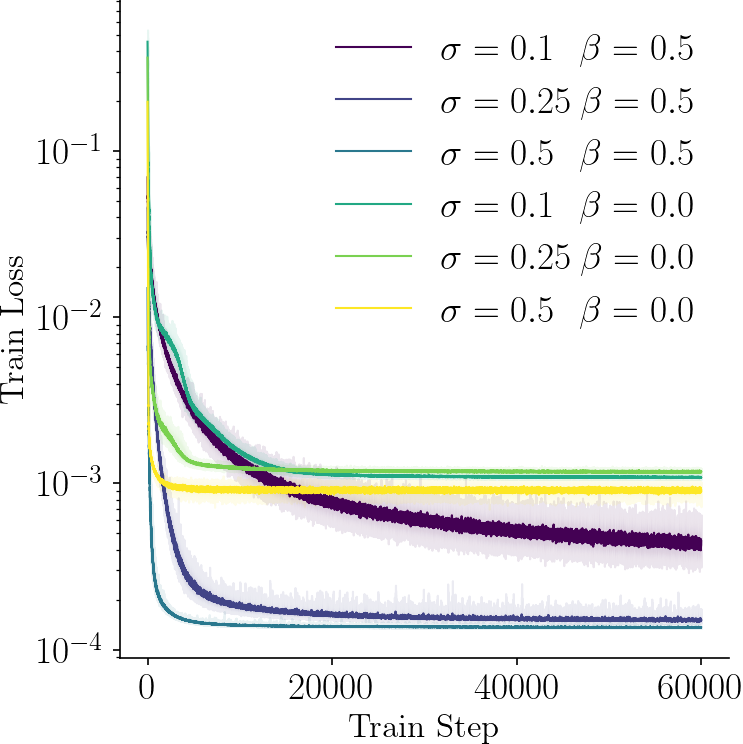

In [32]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()
plt.show()

fig.savefig(os.path.join(figure_path, 'ff_training_loss.svg'), transparent=True)

## Ratemaps

In [33]:
models.keys()

dict_keys(['256_ff_01scale', '256_ff', '256_ff_05scale', '256_ff_01scale_0beta', '256_ff_0beta', '256_ff_05scale_0beta'])

In [9]:
model_name = "256_ff"

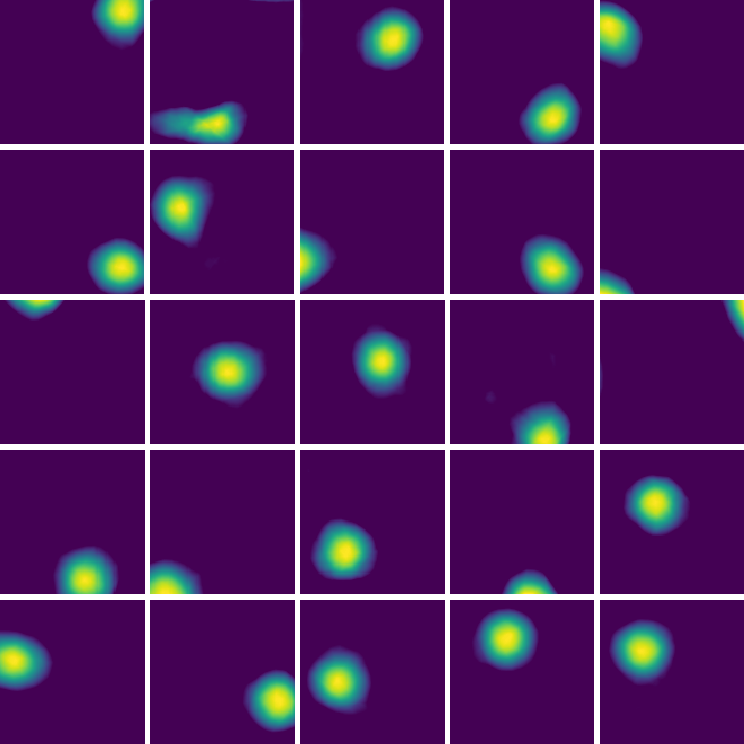

In [10]:
model = models[model_name][0]
ratemaps = get_ratemaps(model, bins=128)

# Plot first 25 ratemaps (active units)
plt_ratemaps = ratemaps[np.mean(ratemaps, axis=(1, 2)) > 0]
# plt_ratemaps = ratemaps
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis", vmax=None) 
plt.show()

# fig.savefig(os.path.join(figure_path, f'ff_ratemaps_{model_name}.svg'), transparent=True)

## Properties

One example

In [167]:
model_name = "256_ff"
model_name = "256_ff_01scale"
# model_name = "256_ff_05scale"
model = models[model_name][0]

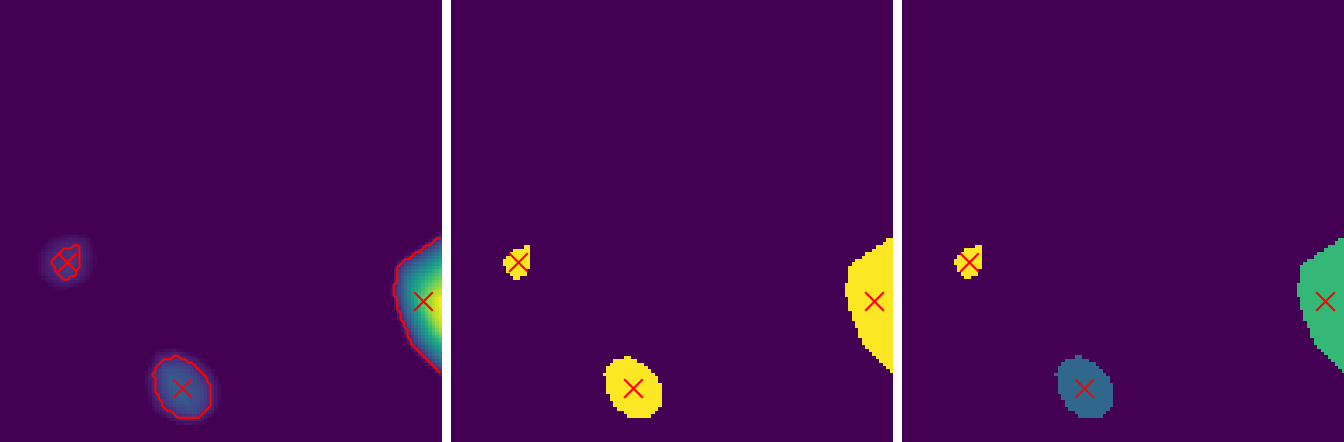

In [168]:
bins = 128

# Get ratemaps
ratemaps = get_ratemaps(model, bins=bins)

# Set threshold (e.g., 1.2 standard deviations above the mean)
threshold = np.mean(ratemaps, axis=(1, 2)) + 1.2 * np.std(ratemaps, axis=(1, 2))      # from Harland et al. 2021
binary_maps = ratemaps > threshold[:, None, None]
binary_map = binary_maps[19]

# Label contiguous regions and extract properties
labeled_map, num_features = label(binary_map)
regions = measure.regionprops(labeled_map)

fig, axs = plt.subplots(ncols=3, figsize=(9, 3))
axs[0].imshow(ratemaps[19], cmap="viridis", origin="lower")
axs[0].contour(binary_map, levels=[0.5], colors="red", linewidths=1)
axs[0].axis("off")
axs[1].imshow(binary_map, cmap="viridis", origin="lower")
axs[1].axis("off")
axs[2].imshow(labeled_map, cmap="viridis", origin="lower")
axs[2].axis("off")

for region in regions:
    axs[0].scatter(region.centroid[1], region.centroid[0], marker="x", color="red", s=80)
    axs[1].scatter(region.centroid[1], region.centroid[0], marker="x", color="red", s=80)
    axs[2].scatter(region.centroid[1], region.centroid[0], marker="x", color="red", s=80)
    
plt.show()

All models

In [34]:
bins = 128
df = []
for model_name, model_list in models.items():
    for k, model in enumerate(model_list): 

        # Get ratemaps and binarize
        ratemaps = get_ratemaps(model, bins=bins)
        threshold = np.mean(ratemaps, axis=(1, 2)) + 1.2 * np.std(ratemaps, axis=(1, 2))
        binary_maps = ratemaps > threshold[:, None, None]
            
        for i, binary_map in enumerate(binary_maps):
        
            # Label contiguous regions and extract properties
            labeled_map, num_features = label(binary_map)
            regions = measure.regionprops(labeled_map)
            
            if len(regions) == 0:
                df.append({
                    'name': model_name_map[model_name],
                    'iteration': k,
                    'unit': i,
                    'area': 0,
                    'centroid': [np.nan, np.nan],
                    'n_fields': 0,
                    'bbox': [np.nan, np.nan, np.nan, np.nan],
                    'mean_rate': np.mean(ratemaps[i]),
                    'peak_rate': np.max(ratemaps[i])
                })
            
            for region in regions: 
                df.append({
                    'name': model_name_map[model_name],
                    'iteration': k,
                    'unit': i,
                    'area': region.area,
                    'centroid': region.centroid,
                    'n_fields': num_features,
                    'bbox': region.bbox,
                    'mean_rate': np.mean(ratemaps[i]),
                    'peak_rate': np.max(ratemaps[i][binary_map])
                })
df = pd.DataFrame(df)
df['active'] = df['n_fields'] > 0  # Active units have at least one field

In [35]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

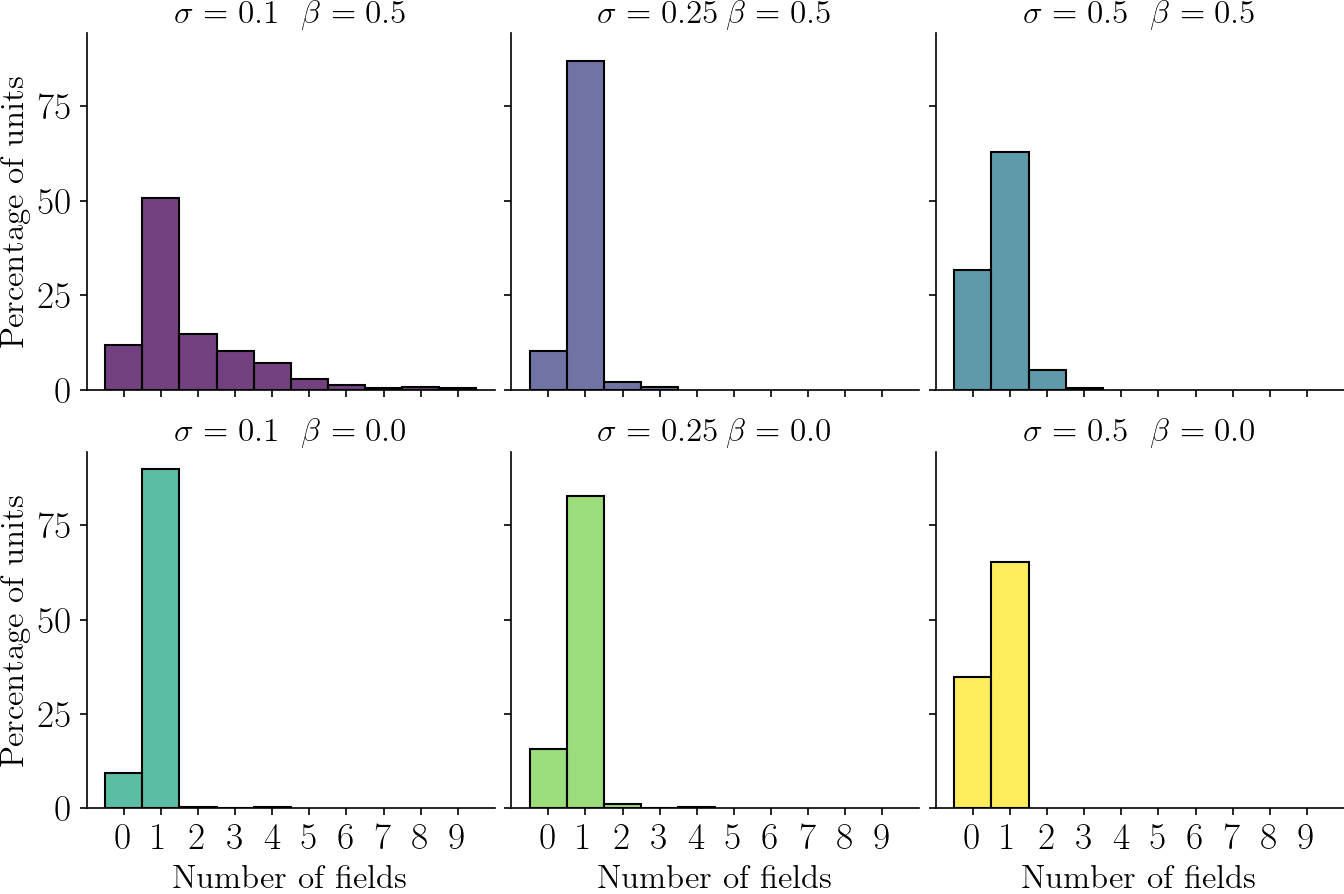

In [36]:
g_df = df.groupby(['name', 'iteration', 'unit']).aggregate(n_fields=('n_fields', 'first')).reset_index()
order = np.array(np.arange(6)).reshape(3, 2).flatten(order='C')
g_df['name'] = pd.Categorical(g_df['name'], [list(model_name_map.values())[i] for i in order])
_colors = [colors[i] for i in order]

g = sns.FacetGrid(
    data=g_df[(g_df.iteration == 0)],  # Only first iteration
    col="name",
    height=3,
    aspect=1,
    col_wrap=3,
)

# Plot each facet with its specific color
for i, (ax, name) in enumerate(zip(g.axes.flatten(), g.col_names)):
    sns.histplot(
        data=g_df[(g_df.iteration == 0) & (g_df.name == name)],
        x="n_fields",
        bins=range(0, 10),
        discrete=True,
        ax=ax,
        color=_colors[i],
        stat='percent'
    )

g.set_axis_labels("Number of fields", "Percentage of units")
g.set(xticks=range(0, 10))
g.set_titles("{col_name}")
plt.show()

g.fig.savefig(os.path.join(figure_path, 'ff_n_fields.svg'), transparent=True)

Field sizes

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_67791/2580868950.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


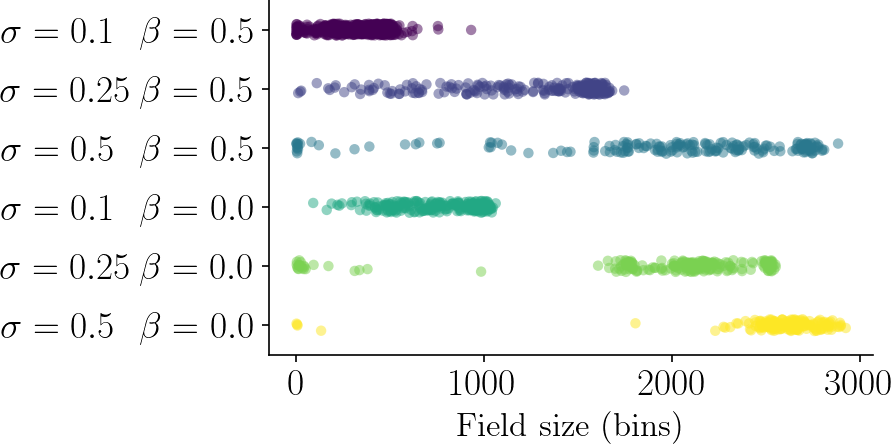

In [37]:
g = sns.catplot(
    data=df[(df.iteration == 0) & df.active], # Only first iteration, only active
    y="name",
    x="area",
    kind="strip",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
)
g.set_axis_labels("Field size (bins)", "")
plt.show()

g.fig.savefig(os.path.join(figure_path, 'ff_field_sizes.svg'), transparent=True)

Peak rates

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_67791/1613860961.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


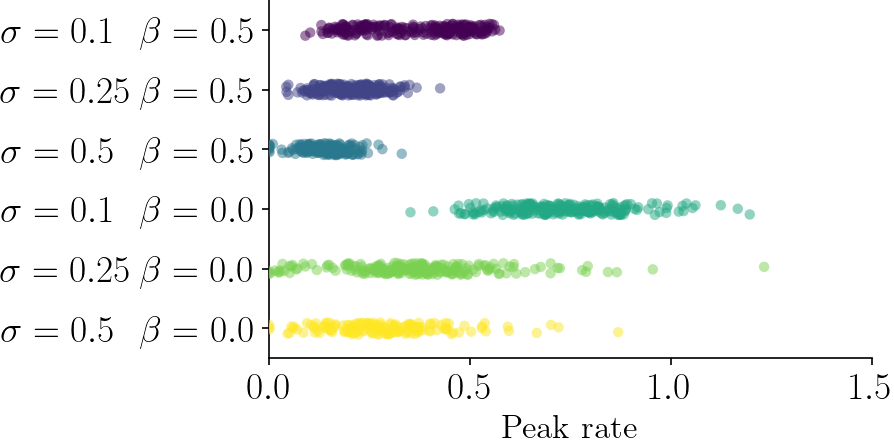

In [38]:
g_df = df.groupby(['name', 'iteration', 'unit']).aggregate(peak_rate=('peak_rate', 'max'), active=('active', 'first')).reset_index()
g_df['name'] = pd.Categorical(g_df['name'], [model_name_map[model_name] for model_name in models.keys()])

g = sns.catplot(
    data=g_df[(g_df.iteration == 0) & g_df.active], # Only first iteration, only active
    y="name",
    x="peak_rate",
    kind="strip",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
)
g.set_axis_labels("Peak rate", "")
g.set(xlim=(0, 1.5))
plt.show()

g.fig.savefig(os.path.join(figure_path, 'ff_peak_rate.svg'), transparent=True) 

Mean rates

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_67791/3528194322.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


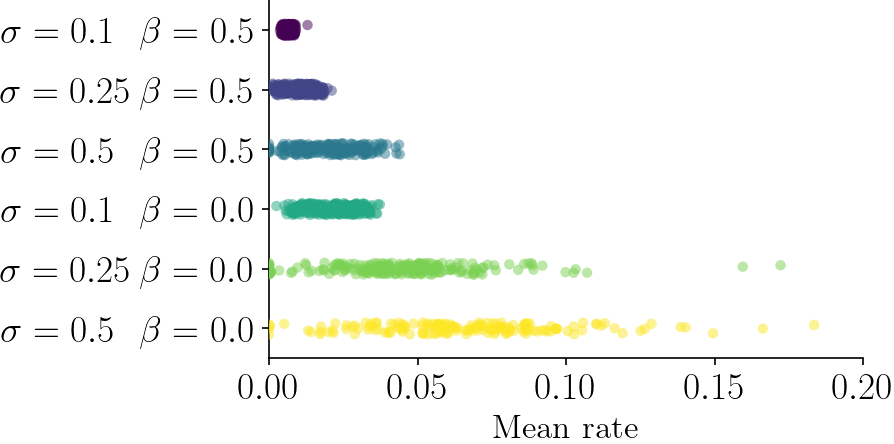

In [39]:
g_df = df.groupby(['name', 'iteration', 'unit']).aggregate(mean_rate=('mean_rate', 'first'), active=('active', 'first')).reset_index()
g_df['name'] = pd.Categorical(g_df['name'], [model_name_map[model_name] for model_name in models.keys()])

g = sns.catplot(
    data=g_df[(g_df.iteration == 0) & g_df.active], # Only first iteration, only active
    y="name",
    x="mean_rate",
    kind="strip",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
)
g.set_axis_labels("Mean rate", "")
g.set(xlim=(0, 0.2))
plt.show()

g.fig.savefig(os.path.join(figure_path, 'ff_mean_rate.svg'), transparent=True)

Active units

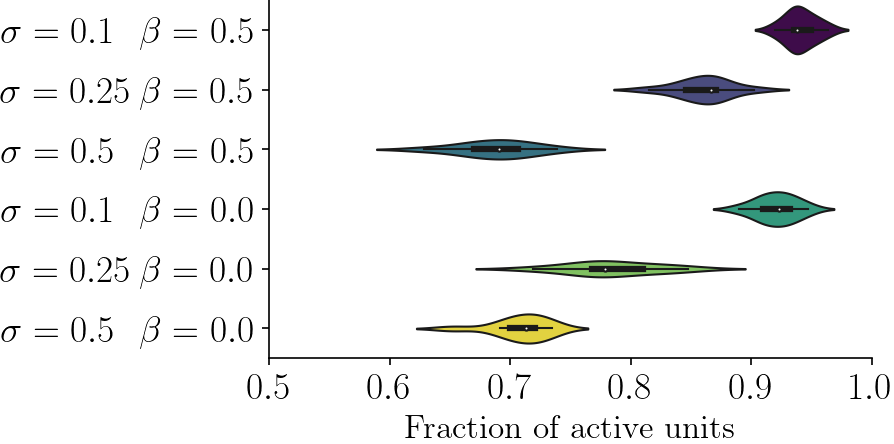

In [46]:
g_df = df.groupby(['name', 'iteration']).aggregate(active=('active', 'mean')).reset_index()
g_df['name'] = pd.Categorical(g_df['name'], [model_name_map[model_name] for model_name in models.keys()])

g = sns.catplot(
    data=g_df,
    y="name",
    x="active",
    kind="violin",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
)
g.set_axis_labels("Fraction of active units", "")
g.set(xlim=(0.5, 1.))
plt.show()

g.fig.savefig(os.path.join(figure_path, 'ff_active_units.svg'), transparent=True)

 ## Peak positions of units

In [21]:
model_name = "256_ff"
model_name = "256_ff_01scale"
model_name = "256_ff_05scale"
model = models[model_name][0]

In [25]:
bins = 128

# Get ratemaps
ratemaps = get_ratemaps(model, bins=bins)

# Find peak positions
peak_idx = np.argmax(ratemaps.reshape(-1, bins*bins), axis=-1)
x = np.linspace(-1, 1, bins)
y = x.copy()
xx, yy = np.meshgrid(x,y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
peak_loc = grid[peak_idx]

# Find units with nonzero values
mask = df[(df.name == model_name_map[model_name]) & (df.iteration == 0)].groupby(['unit']).aggregate(active=('active', 'first')).reset_index()['active'].values

print(f"Resolution: {2/bins:.3f}")
print(f"Percentage of units meeting criterion: {np.mean(mask) * 100:.2f}%")

Resolution: 0.016
Percentage of units meeting criterion: 68.36%


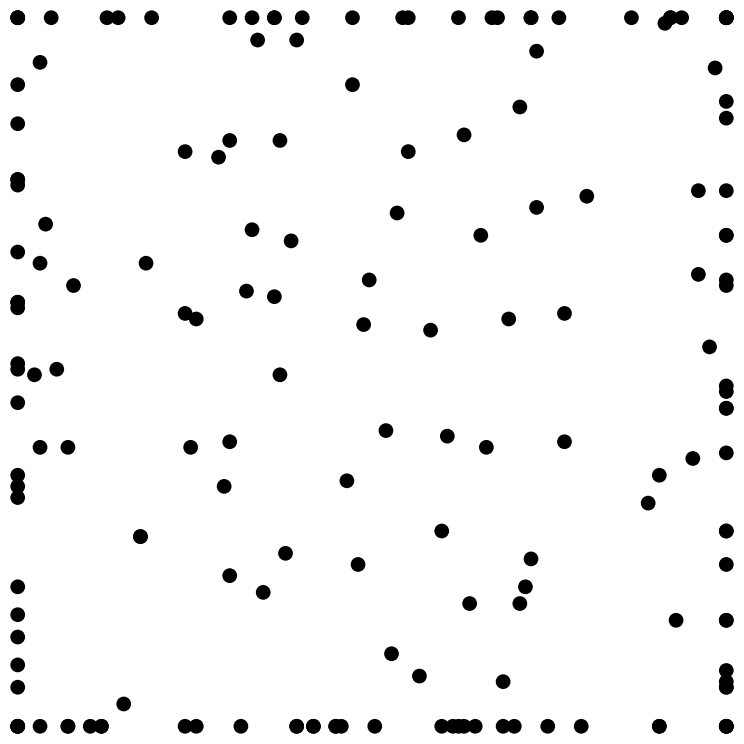

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(peak_loc[mask, 0], peak_loc[mask, 1], marker="o", color="black", s=50, alpha=1, edgecolors='none')
ax.axis("off")
ax.set_ylim(-1.05, 1.05)
ax.set_xlim(-1.05, 1.05)
ax.invert_yaxis()
plt.show()
# fig.savefig(os.path.join(figure_path, f'ff_peak_positions_{model_name}.svg'), transparent=True)

## Similarity structure / Error maps

In [122]:
model_name = "256_ff"
model = models[model_name][0]

pos_name = "corner"
scale = model.scale
beta = model.beta

positions = {
    'center': [512, 512],
    'corner': [0, 0],
    'bottom': [256, 512]
}

pos = positions[pos_name]

In [123]:
bins = 1024
ratemaps = get_ratemaps(model, bins=bins)

p = ratemaps.reshape(256, -1).T 

In [124]:
(bins, bins)

(1024, 1024)

In [125]:
pos_flat = np.ravel_multi_index(pos, (bins, bins))

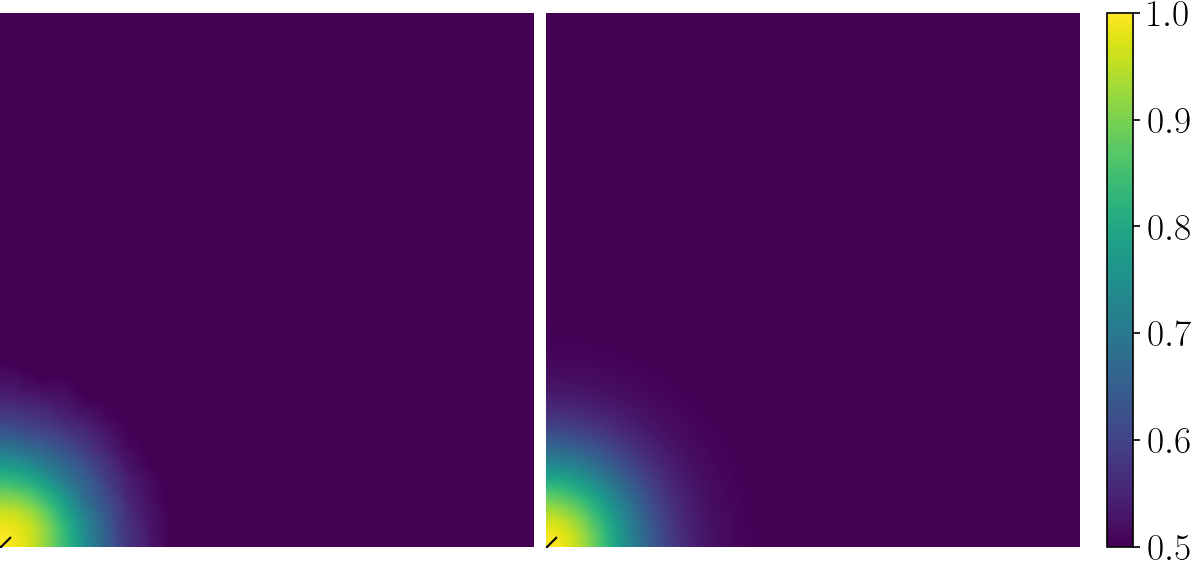

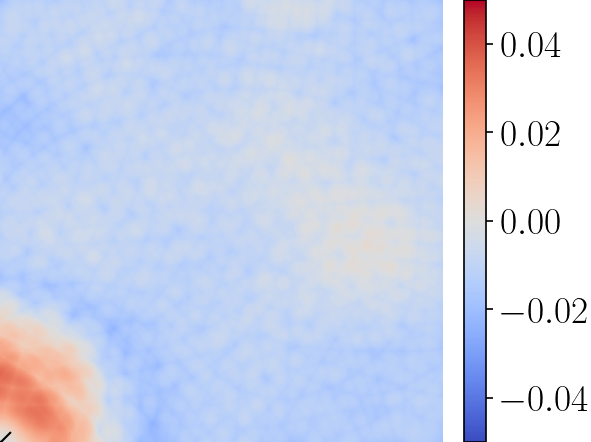

In [126]:
x = np.linspace(-1, 1, bins)
y = x.copy()
xx, yy = np.meshgrid(x,y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (bins, bins))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)
grid_corr = (1 - beta) * grid_corr + beta

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

# Spatial representations
im = axs[0].imshow(corr.reshape(bins, bins), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(bins, bins), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)

plt.show()

fig.savefig(os.path.join(figure_path, f'ff_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(4, 4))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
im = axs.imshow((corr - grid_corr).reshape(bins, bins), origin="lower", cmap="coolwarm", vmin=-0.05, vmax=0.05)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)

plt.show()

fig.savefig(os.path.join(figure_path, f'ff_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

## Decoding

In [4]:
def compute_top_n_unit_error(model, n, res, eval_res=129, shuffle=False):
    
    # Get ratemaps
    x = np.linspace(-1, 1, res+1)[:-1] + np.diff(np.linspace(-1, 1, res+1))[0]/2
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    r = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    u = torch.tensor(r, dtype=torch.float32)
    p = model.spatial_representation(u).detach().numpy().T
    
    # Find peak location for each unit
    peak_idx = np.argmax(p, axis=-1)
    if shuffle:
        np.random.shuffle(peak_idx)
    
    # Get locations of peaks on grid
    peak_loc = r[peak_idx]
    
    # Now, get the eval grid
    x = np.linspace(-1, 1, eval_res)
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    eval_r = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    u = torch.tensor(eval_r, dtype=torch.float32)
    eval_p = model.spatial_representation(u).detach().numpy().T
    
    # Get top n active units for each position, and their peak locations
    top_n = np.argsort(eval_p, axis=0)[-n:]     # (n, eval_res**2)
    top_n_peak_loc = peak_loc[top_n]            # (n, eval_res**2, 2)  
    
    # Compute their activity at each position to weight the decoded position
    weights = eval_p[top_n, np.arange(eval_res**2)[None, :]]  # (n, eval_res**2)
    
    # Use einsum to compute weighted average of top n units
    # This performs an elementwise multiplication of the weights at each position with the peak locations and then sums over the units
    decoded_pos = np.einsum("ijk,ij->jk", top_n_peak_loc, weights) / np.sum(weights, axis=0)[:, None]
    
    # Compute error (euclidean distance between decoded and actual position)
    return np.linalg.norm(decoded_pos - eval_r, axis=-1).reshape(eval_res, eval_res)
          

In [5]:
model_name = "256_ff"
model = models[model_name][0]

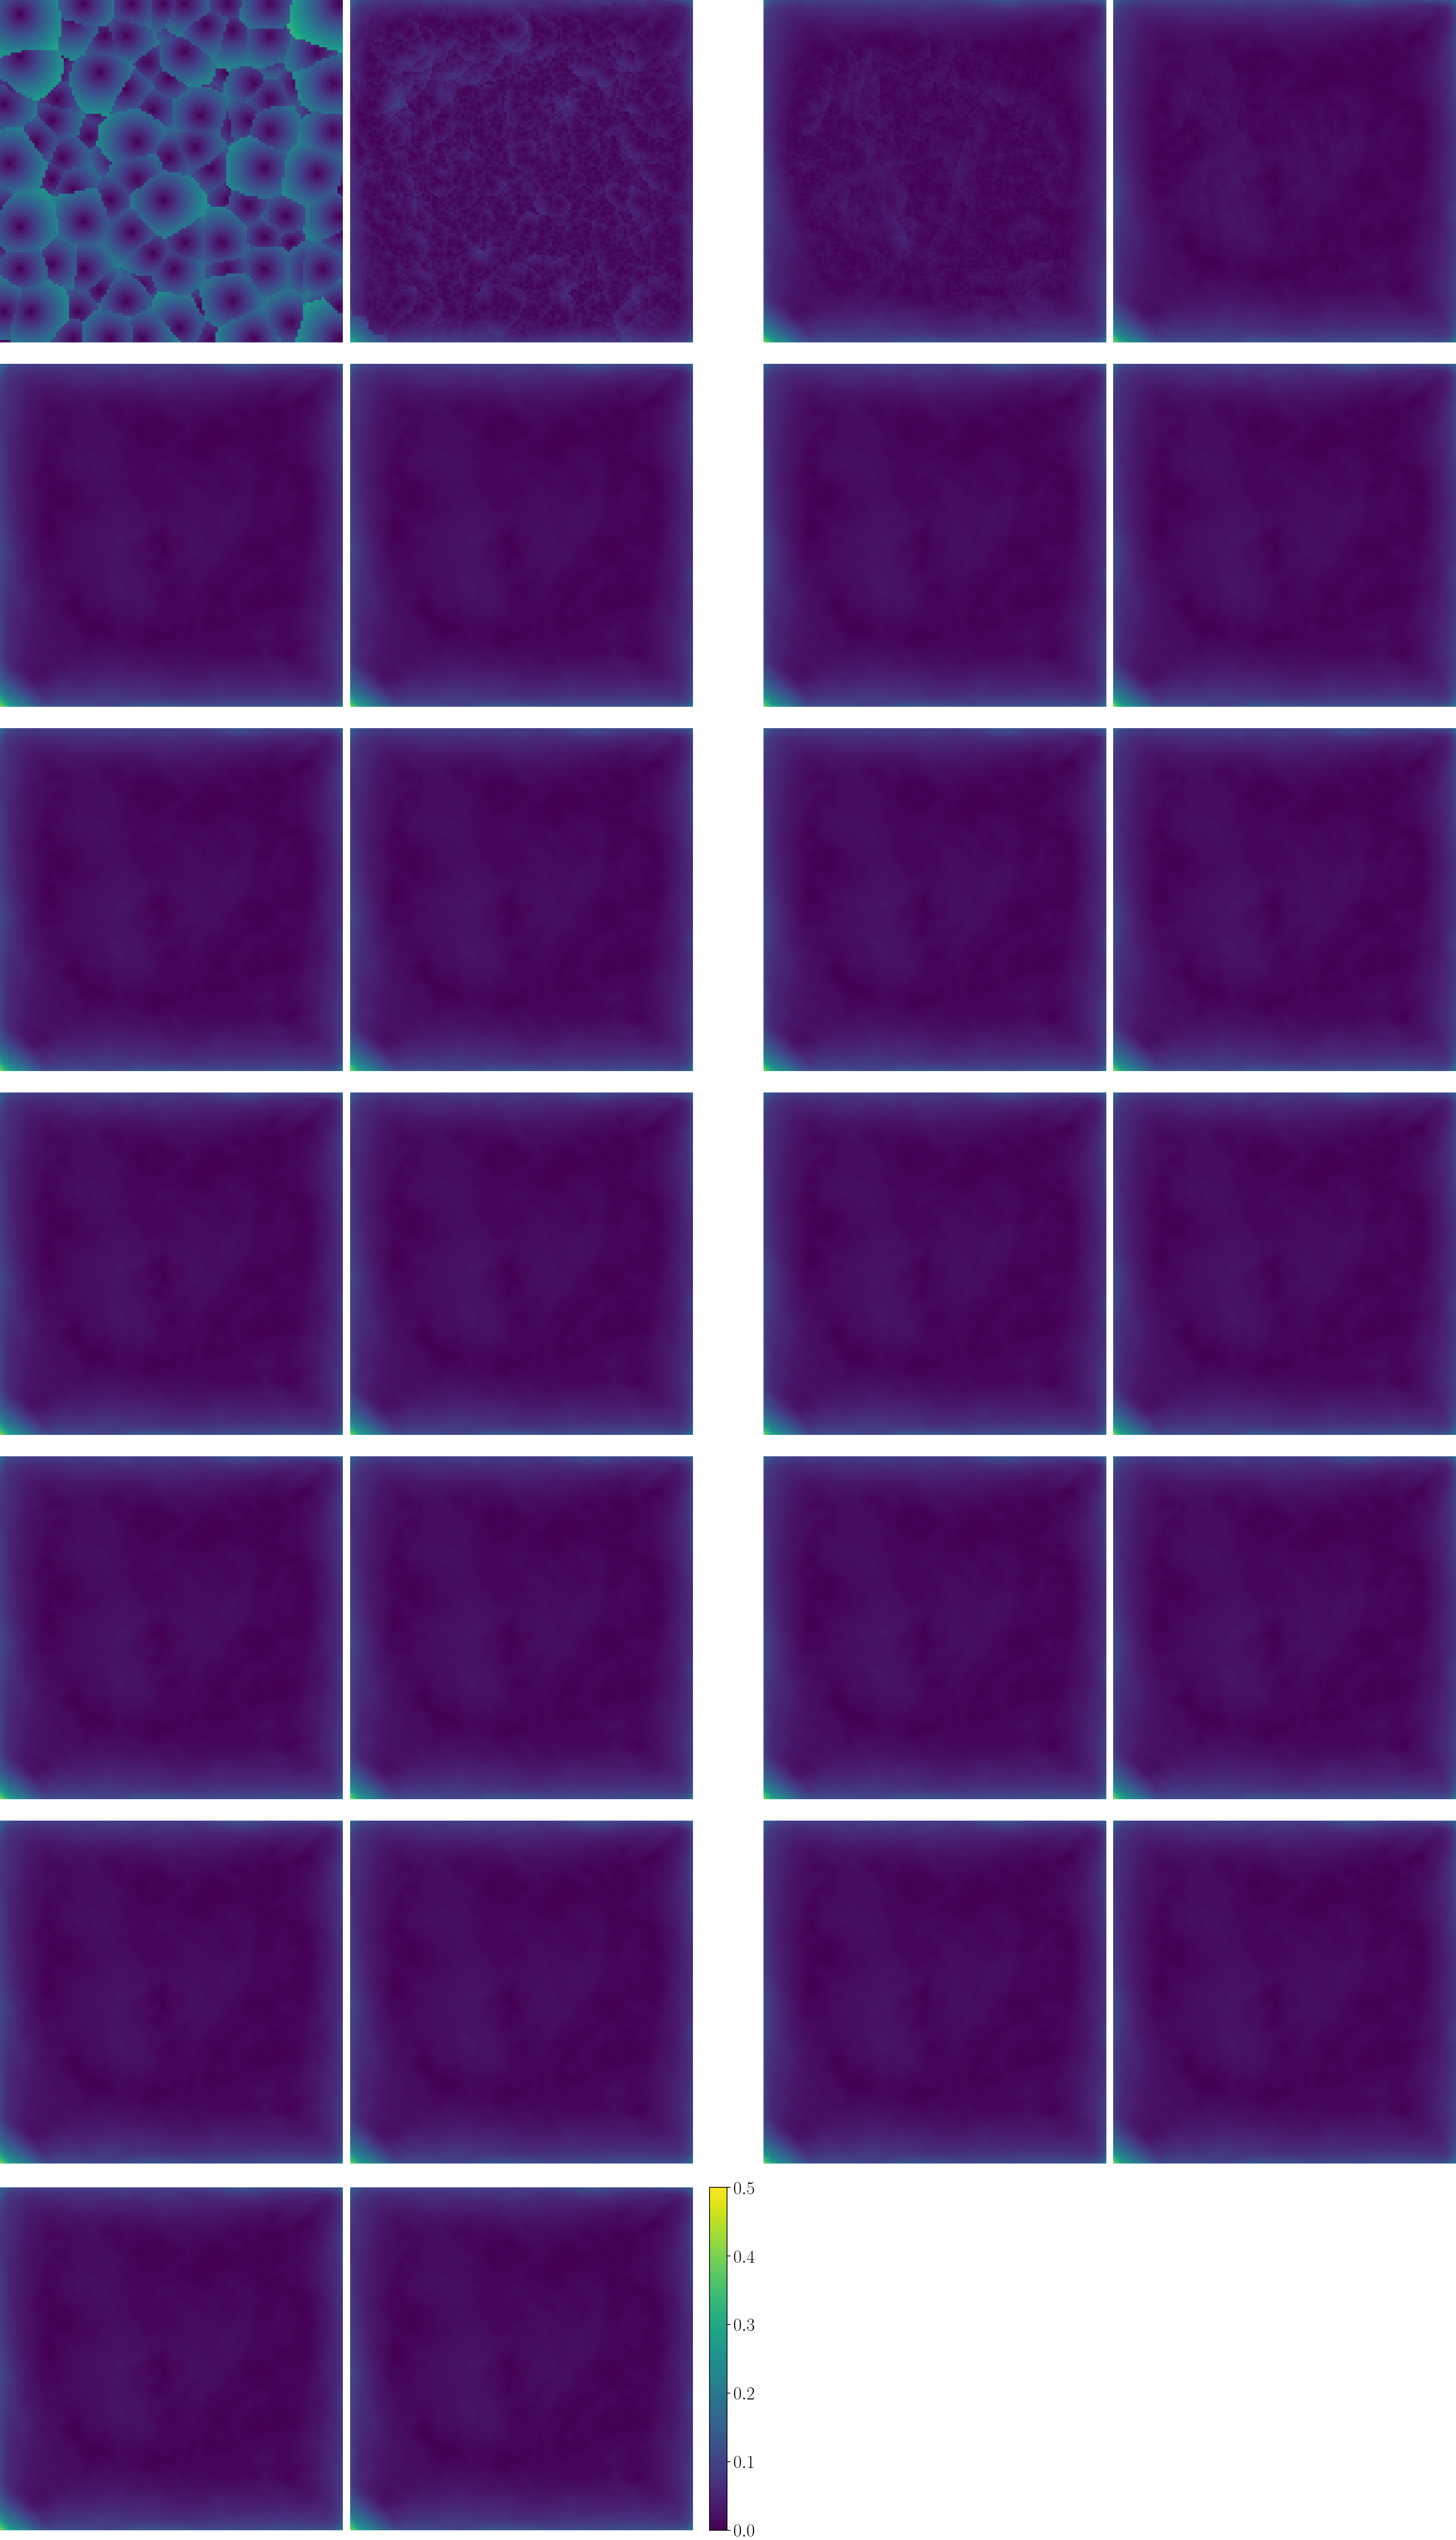

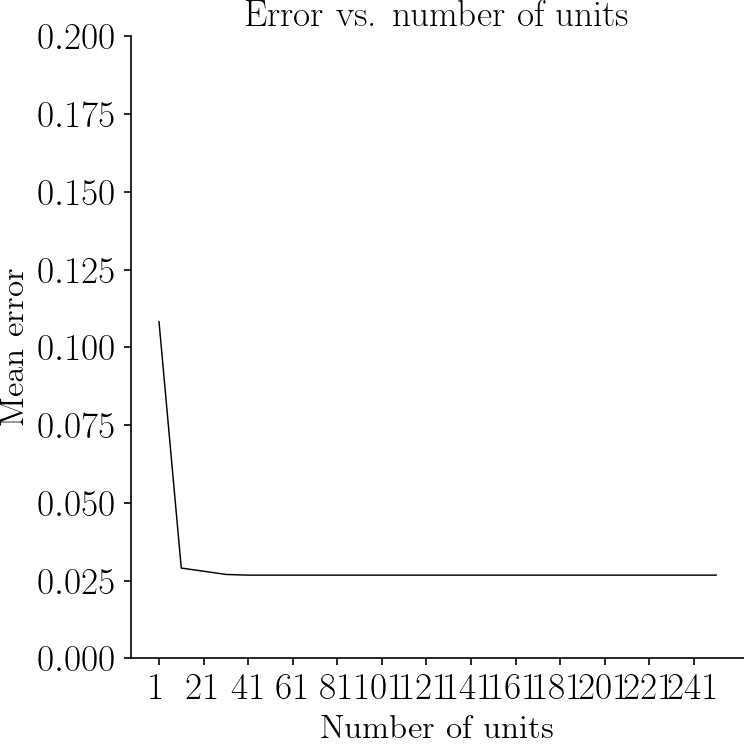

In [97]:
# ----------------------- Params -----------------------

ns = np.arange(1, 256)[::10]            # no. of top units to use for decoding
res = 32                        # no. of points on grid to compute peaks
# weight_by_activity = True       # weight decoded position by activity of units

# --------------------- Decoding ----------------------

errors = []

# Col wrap after
cols = 4
rows = len(ns) // cols + 1

fig, axs = plt.subplots(figsize=(cols * 5, rows * 5), ncols=cols, nrows=rows, sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
for k, n in enumerate(ns):

    # Get axis
    ax = axs[k]
    
    # Compute error res, eval_res=129
    error = compute_top_n_unit_error(model, n, res=res, eval_res=129, shuffle=False)

    # Plot error map
    im = ax.imshow(error, origin="lower", vmin=0, vmax=0.5)
    ax.axis("off")
    ax.set_title(f"")
    if k == len(ns) - 1:
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=.05)

    # Append to list
    errors.append(error.mean())

for k in range(len(ns), len(axs)):
    axs[k].axis("off")

# fig.suptitle("Error maps")
# plt.tight_layout()
plt.show()

# fig.savefig(os.path.join(figure_path, f'dense_error_maps_{model_name}.svg'), transparent=True)

# Plot error vs. n
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(ns, errors, "-k", linewidth=0.7)
ax.set_ylim(0, 0.2)
if len(ns) > 10:
    ax.set_xticks(ns[::2])
else:
    ax.set_xticks(ns)
ax.set_xlabel("Number of units")
ax.set_ylabel("Mean error")
ax.set_title("Error vs. number of units")

plt.show()


Model comparison

In [129]:
s_models = ["256_ff", "256_ff_01scale", "256_ff_05scale", "256_ff_0beta", "256_ff_025beta", "256_ff_075beta"]
s_models = list(models.keys())

# Evaluate mean error for different number of units
res = 32
ns = np.arange(2, 30)[::2]
errors = {name: [] for name in s_models}
_errors = {name + ', shuffled': [] for name in models.keys()}
errors = {**errors, **_errors}
for name in s_models:
    for m in models[name]:
        error = [compute_top_n_unit_error(m, n, res=res, eval_res=129, shuffle=False).mean() for n in ns]
        errors[name].append(error)
        error = [compute_top_n_unit_error(m, n, res=res, eval_res=129, shuffle=True).mean() for n in ns]
        errors[name + ', shuffled'].append(error)

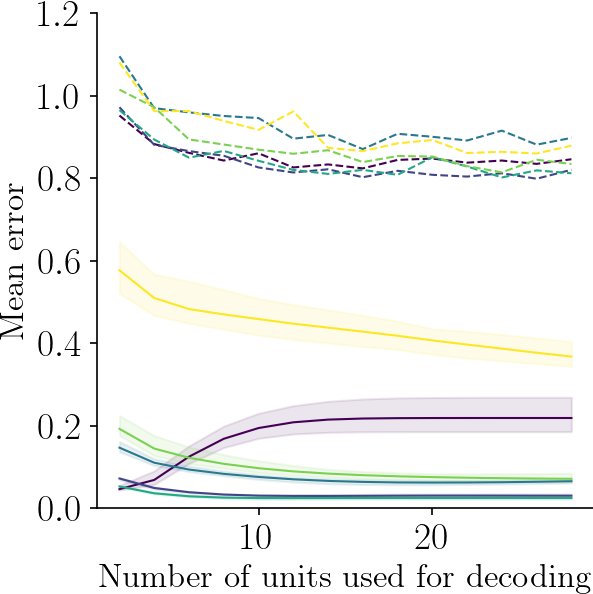

In [134]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(s_models))]

# Plot error vs. n
fig, ax = plt.subplots(figsize=(4, 4))
for i, name in enumerate(models.keys()):
    if not name in errors:
        continue
    error = errors[name]
    ax.plot(ns, np.mean(error, axis=0), label=model_name_map[name], color=colors[i], lw=1.)
    ax.fill_between(ns, np.min(error, axis=0), np.max(error, axis=0), alpha=0.1, color=colors[i])
    error = errors[name + ', shuffled']
    ax.plot(ns, np.mean(error, axis=0), color=colors[i], lw=1, linestyle="--")
    # ax.fill_between(ns, np.min(error, axis=0), np.max(error, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Number of units used for decoding")
ax.set_ylabel("Mean error")
# ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(2, 1))
# ax.legend(frameon=False)
ax.set_ylim(0, 1.2)
# Aspect equal
# ax.set_aspect("equal")
plt.show()

fig.savefig(os.path.join(figure_path, 'ff_error_top_n_no_legend.svg'), transparent=True)

### Compare different decoding methods

In [65]:
eval_res = 129      # resolution of the grid used to evaluate the error. should be the same for all

#### Option 1: Top n units

In [76]:
ns = np.arange(2, 50)
max_n = 0
for model in models["256_ff"]:
    errors = [compute_top_n_unit_error(model, n, res=res, eval_res=129, shuffle=False).mean() for n in ns]
    max_n = max(max_n, ns[np.argmin(errors)])
print(f"Max n: {max_n}")

Max n: 44


In [66]:
n = 44              # based on prior analysis
res = 32            # resolution of the grid used to determine the peak location of the units
shuffle = False     # whether to shuffle the order of the units

error_top_n = compute_top_n_unit_error(model, n, res, eval_res=eval_res, shuffle=shuffle)

#### Option 2: Linear decoder

In [67]:
def train_decoder(model, train_res=32, train_steps=5000):
    
    # Define decoder and optimizer
    decoder = LinearDecoder(n_in=256, n_out=2)
    optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    
    x = np.linspace(-1, 1, train_res+1)[:-1] + np.diff(np.linspace(-1, 1, train_res+1))[0]/2
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    grid = torch.tensor(grid, dtype=torch.float32)
    
    # Train decoder
    decoder_history = []
    progress = tqdm(range(train_steps))
    for i in progress:
    
        # r = torch.tensor(np.random.uniform(-1, 1, (64, 2)), dtype=torch.float32)

        # Subsample random batch from grid
        idx = np.random.choice(grid.shape[0], 64, replace=False)
        r = grid[idx]

        # Get spatial representation
        p = model.spatial_representation(r).detach()
    
        # Reshape to (bs, n_out)
        p = torch.reshape(p, (-1, p.shape[-1]))
    
        # Train decoder
        loss = decoder.train_step(x=p, y=r, optimizer=optimizer)
    
        # Save loss
        decoder_history.append(loss)
    
        # Update progress bar
        if i % 10 == 0:
            progress.set_description(f"loss: {loss:>7f}")
            
    return decoder, decoder_history

def evaluate_decoder(decoder, model, eval_res):
    x = np.linspace(-1, 1, eval_res)
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype= torch.float32)
    p = model.spatial_representation(u).detach()

    # Use decoder to get decoded position
    r = decoder(p).detach().numpy()

    # Compute error as the euclidean distance between decoded and actual position
    error = np.linalg.norm(r - u.detach().numpy(), axis=-1)

    return error.reshape(eval_res, eval_res)

loss: 0.000126: 100%|██████████| 5000/5000 [00:01<00:00, 2992.40it/s]


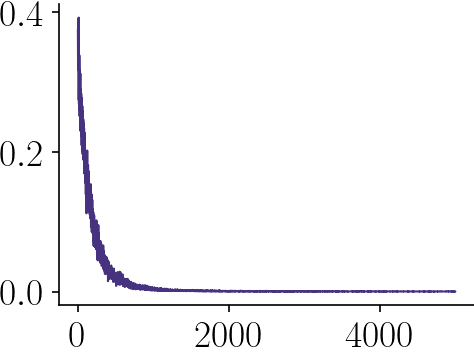

In [68]:
# For a more fair comparison, use the same resolution as the top n units for training
train_res = 32

# Train decoder
decoder, decoder_history = train_decoder(model, train_res=train_res)
        
plt.plot(decoder_history)
plt.show()

# Evaluate decoder
error_decoder = evaluate_decoder(decoder, model, eval_res=eval_res)

#### Option 3: Population decoding

In [69]:
def population_decoding(p, memory, r_memory):
    """Population decoding scheme: decode location as location r_memory 
       corresponding to most similar (closest) population vector in memory
       to current population vector p

    Args:
        p (N, n_p): population vectors to be decoded
        memory (M, n_p): memory of population vectors
        r_memory (M, 2): physical locations of memory vectors
    """
    dists = np.sum((p[None] - memory[:,None])**2, axis = -1) # (M, N)
    inds = np.argmin(dists, axis = 0) # (N)
    decoded_trajectories = r_memory[inds] #(N, 2)
    return decoded_trajectories


def get_memory(model, memory_res=32):
    x = np.linspace(-1, 1, memory_res+1)[:-1] + np.diff(np.linspace(-1, 1, memory_res+1))[0]/2
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    r_memory = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    u = torch.tensor(r_memory, dtype=torch.float32)
    memory = model.spatial_representation(u).detach().numpy()
    return memory, r_memory

In [70]:
memory_res = 32

# Form memory
x = np.linspace(-1, 1, memory_res+1)[:-1] + np.diff(np.linspace(-1, 1, memory_res+1))[0]/2
y = x.copy()
xx, yy = np.meshgrid(x,y)
r_memory = np.stack([xx.ravel(), yy.ravel()], axis=-1)
u = torch.tensor(r_memory, dtype=torch.float32)
memory = model.spatial_representation(u).detach().numpy()

In [71]:
# Get eval grid
x = np.linspace(-1, 1, eval_res)
y = x.copy()
xx, yy = np.meshgrid(x,y)
eval_r = np.stack([xx.ravel(), yy.ravel()], axis=-1)
u = torch.tensor(eval_r, dtype=torch.float32)

# Get spatial representation and decode
eval_p = model.spatial_representation(u).detach().numpy()
r_decoded = population_decoding(eval_p, memory, r_memory) # beware, this is N^2 :O
 
# Compute error as the euclidean distance between decoded and actual position
error_pop = np.linalg.norm(r_decoded - eval_r, axis=-1)
error_pop = error_pop.reshape(eval_res, eval_res)

#### Comparison

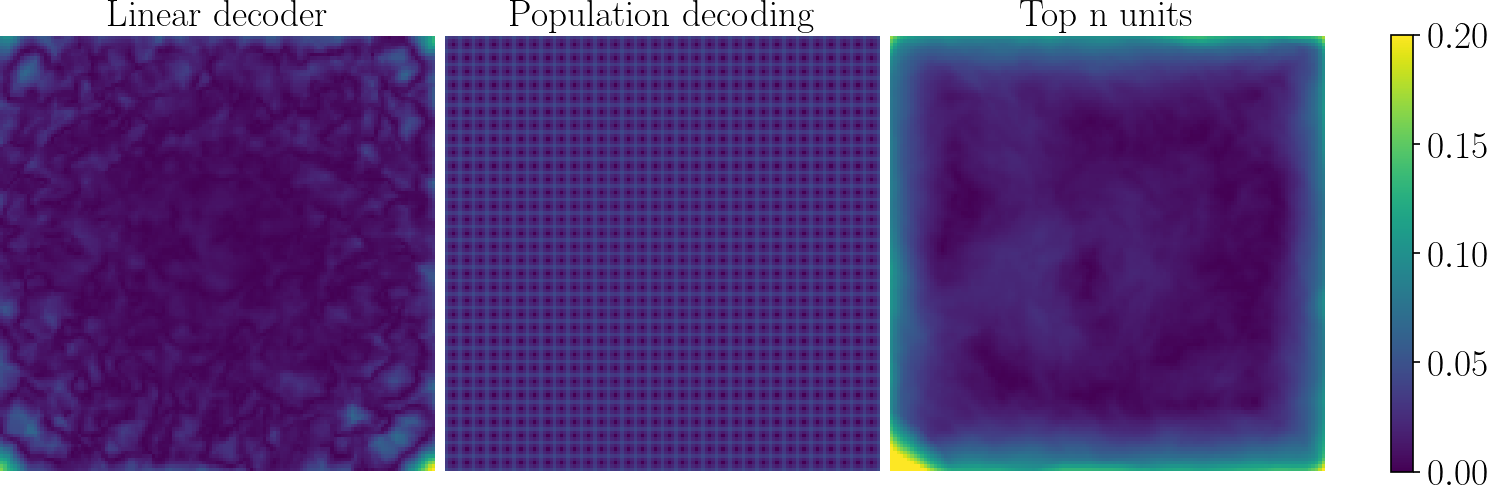

In [72]:
max_val = 0.2
fig, axs = plt.subplots(figsize=(10, 5), ncols=3, sharex=False, sharey=False, constrained_layout=True)
im = axs[0].imshow(error_decoder, origin="lower", vmin=0, vmax=max_val)
axs[0].set_title("Linear decoder")
axs[0].axis("off")
im = axs[1].imshow(error_pop, origin="lower", vmin=0, vmax=max_val)
axs[1].set_title("Population decoding")
axs[1].axis("off")
axs[2].imshow(error_top_n, origin="lower", vmin=0, vmax=max_val)
axs[2].set_title("Top n units")
axs[2].axis("off")
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.0165)
plt.show()

In [73]:
fig.savefig(os.path.join(figure_path, 'ff_decoding_comparison_error_map.png'), transparent=True)

In [43]:
train_res = 32

errors = []
for model in models["256_ff"]:
    
    # Option 1: Top n units
    error_top_n = compute_top_n_unit_error(model, n, res=train_res, eval_res=eval_res, shuffle=False)
    
    # Option 2: Linear decoder
    error_decoder = evaluate_decoder(train_decoder(model, train_res)[0], model, eval_res=eval_res)
    
    # Option 3: Population decoding
    
    # Form memory
    memory, r_memory = get_memory(model, memory_res=train_res)
    
    # Get eval grid
    x = np.linspace(-1, 1, eval_res)
    y = x.copy()
    xx, yy = np.meshgrid(x, y)
    eval_r = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    u = torch.tensor(eval_r, dtype=torch.float32)
     
    # Compute error as the euclidean distance between decoded and actual position
    eval_p = model.spatial_representation(u).detach().numpy()
    error_pop = np.linalg.norm(population_decoding(eval_p, memory, r_memory) - eval_r, axis=-1).reshape(eval_res, eval_res)
    
    errors.append(pd.DataFrame({
        "method": ["Top n units", "Linear decoder", "Population decoding"],
        "mean_error": [error_top_n.mean(), error_decoder.mean(), error_pop.mean()],
        "max_error": [error_top_n.max(), error_decoder.max(), error_pop.max()]
    }))
errors = pd.concat(errors, ignore_index=True)

loss: 0.000086: 100%|██████████| 5000/5000 [00:01<00:00, 3412.13it/s]


In [44]:
errors.to_csv(os.path.join(results_path, "ff_decoding_comparison.csv"), index=False)

In [48]:
errors = pd.read_csv(os.path.join(results_path, "ff_decoding_comparison.csv"))

In [49]:
colors = plt.get_cmap("viridis")(np.linspace(0, 1, 3))

In [50]:
# Order by method: "Linear decoder", "Population decoding", "Top n units"
errors["method"] = pd.Categorical(errors["method"], ["Linear decoder", "Population decoding", "Top n units"])

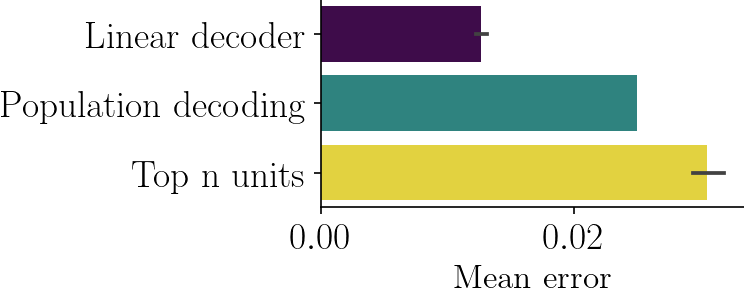

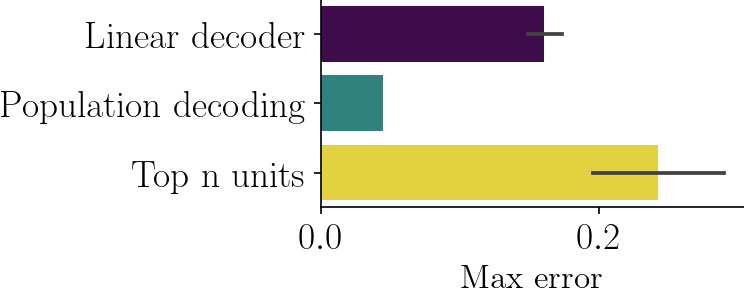

In [53]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.barplot(data=errors, y="method", x="mean_error", palette=colors, ax=ax)
ax.set_xlabel("Mean error")
ax.set_ylabel("")
plt.show()

fig.savefig(os.path.join(figure_path, 'ff_decoding_comparison_mean_error.svg'), transparent=True)

fig, ax = plt.subplots(figsize=(5, 2))
sns.barplot(data=errors, y="method", x="max_error", palette=colors, ax=ax)
ax.set_xlabel("Max error")
ax.set_ylabel("")
plt.show()

fig.savefig(os.path.join(figure_path, 'ff_decoding_comparison_max_error.svg'), transparent=True)

# Coordinate transformation

In [107]:
def trapezoidal_transformation(x, y, x0, shrink_rate):
    """Apply trapezoidal transformation to y based on x, starting from x0"""
    return x, np.where(x > x0, y * (1 - shrink_rate * (x - x0)), y)

def uniform_scaling(x, y, scale):
    """Apply uniform scaling to x and y"""
    return x * scale, y * scale

def rotate(x, y, angle):
    """Rotate x and y by angle"""
    return x * np.cos(angle) - y * np.sin(angle), x * np.sin(angle) + y * np.cos(angle)

def y_stretch(x, y, scale):
    """Stretch y by scale"""
    return x, y * scale

def x_stretch(x, y, scale):
    """Stretch x by scale"""
    return x * scale, y


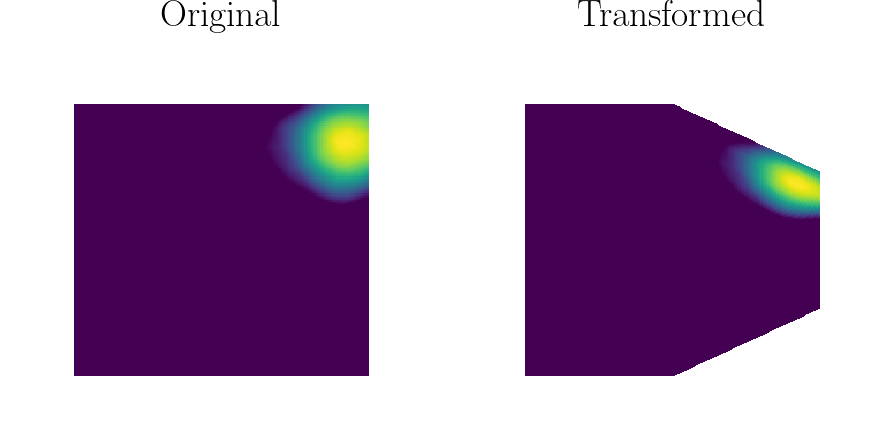

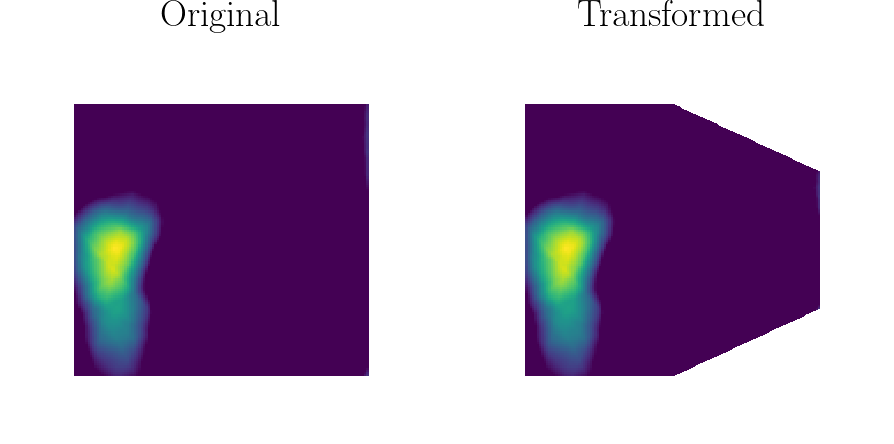

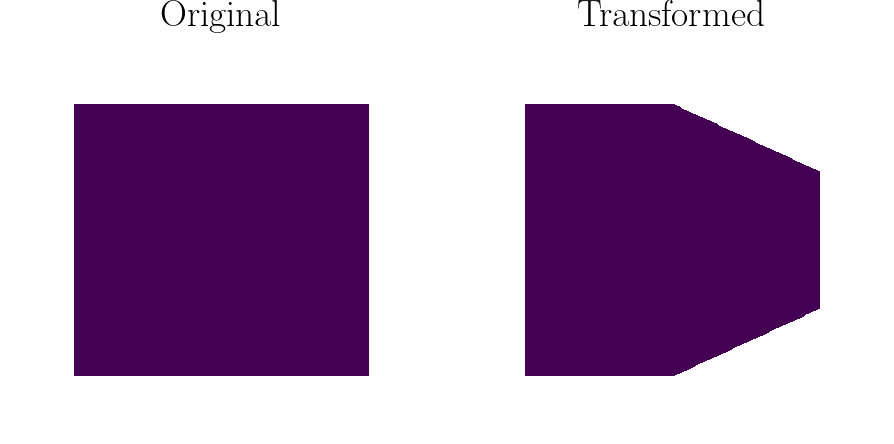

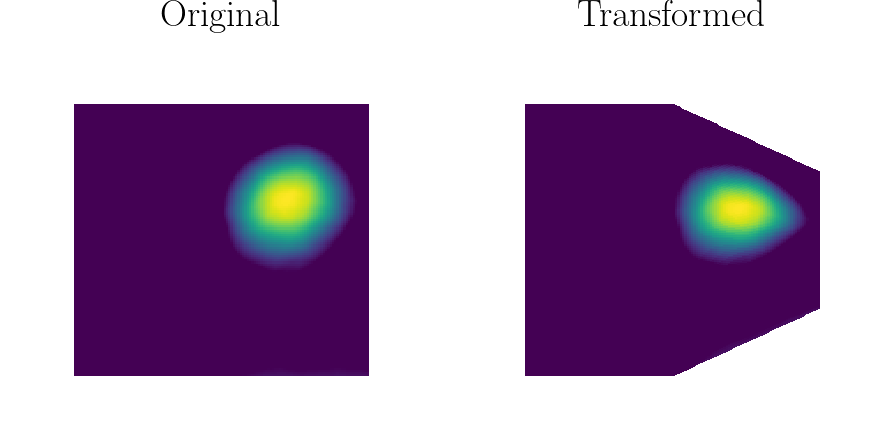

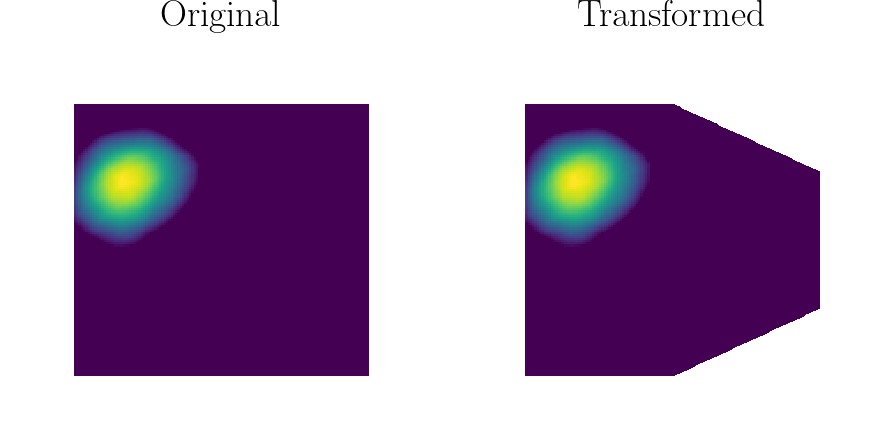

In [114]:
model_name = "256_ff"
model = models[model_name][0]

bins = 128
x_lims = 1.5
y_lims = 1.5

transformation = trapezoidal_transformation
transformation_kwargs = {"x0": 0, "shrink_rate": 0.5}
# transformation_kwargs = {"scale": 0.5}
# transformation_kwargs = {"angle": 45}
# transformation_kwargs = {"scale": 0.5}

# Create grid
x = np.linspace(-1, 1, bins)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# Apply transformation
xx_trans, yy_trans = transformation(xx, yy, **transformation_kwargs)

# Get ratemaps, both original and transformed
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
# u_transformed = torch.tensor(np.stack([xx_trans.ravel(), yy_trans.ravel()], axis=-1), dtype=torch.float32)
u_transformed = u
p = model.spatial_representation(u).detach().numpy().T
p_transformed = model.spatial_representation(u_transformed).detach().numpy().T
ratemap = p.reshape(-1, bins, bins)
ratemap_transformed = p_transformed.reshape(-1, bins, bins)

# Compute the edges for the grid
x_edges = np.linspace(-1, 1, bins + 1)
y_edges = np.linspace(-1, 1, bins + 1)
xx_edges, yy_edges = np.meshgrid(x_edges, y_edges)

# Apply transformation to edges
xx_edges_trans, yy_edges_trans = transformation(xx_edges, yy_edges, **transformation_kwargs)

for i in range(5):
    fig, ax = plt.subplots(figsize=(6, 3), ncols=2)
    # ax[0].imshow(ratemap[i],
    c = ax[0].pcolormesh(xx_edges, yy_edges, ratemap[i], shading='auto', cmap='viridis')
    ax[0].axis("off")
    ax[0].set_title("Original")
    ax[0].set_xlim(-x_lims, x_lims)
    ax[0].set_ylim(-y_lims, y_lims)
    c = ax[1].pcolormesh(xx_edges_trans, yy_edges_trans, ratemap_transformed[i], shading='auto', cmap='viridis')
    ax[1].axis("off")
    ax[1].set_title("Transformed")
    ax[1].set_xlim(-x_lims, x_lims)
    ax[1].set_ylim(-y_lims, y_lims)
    plt.show()


## Maps across different contexts

In [70]:
model_name = "256_ff_context"
model = models[model_name][0]

KeyError: '256_ff_context'

In [46]:
n_cells = 10
contexts = np.linspace(-2, 2, 10)
maps = []
for context in contexts:
    ratemaps = get_ratemaps(model, bins=64, timesteps=10, n_traj=100000, context=context, context_in_initial=True)
    maps.append(ratemaps)
maps = np.array(maps)


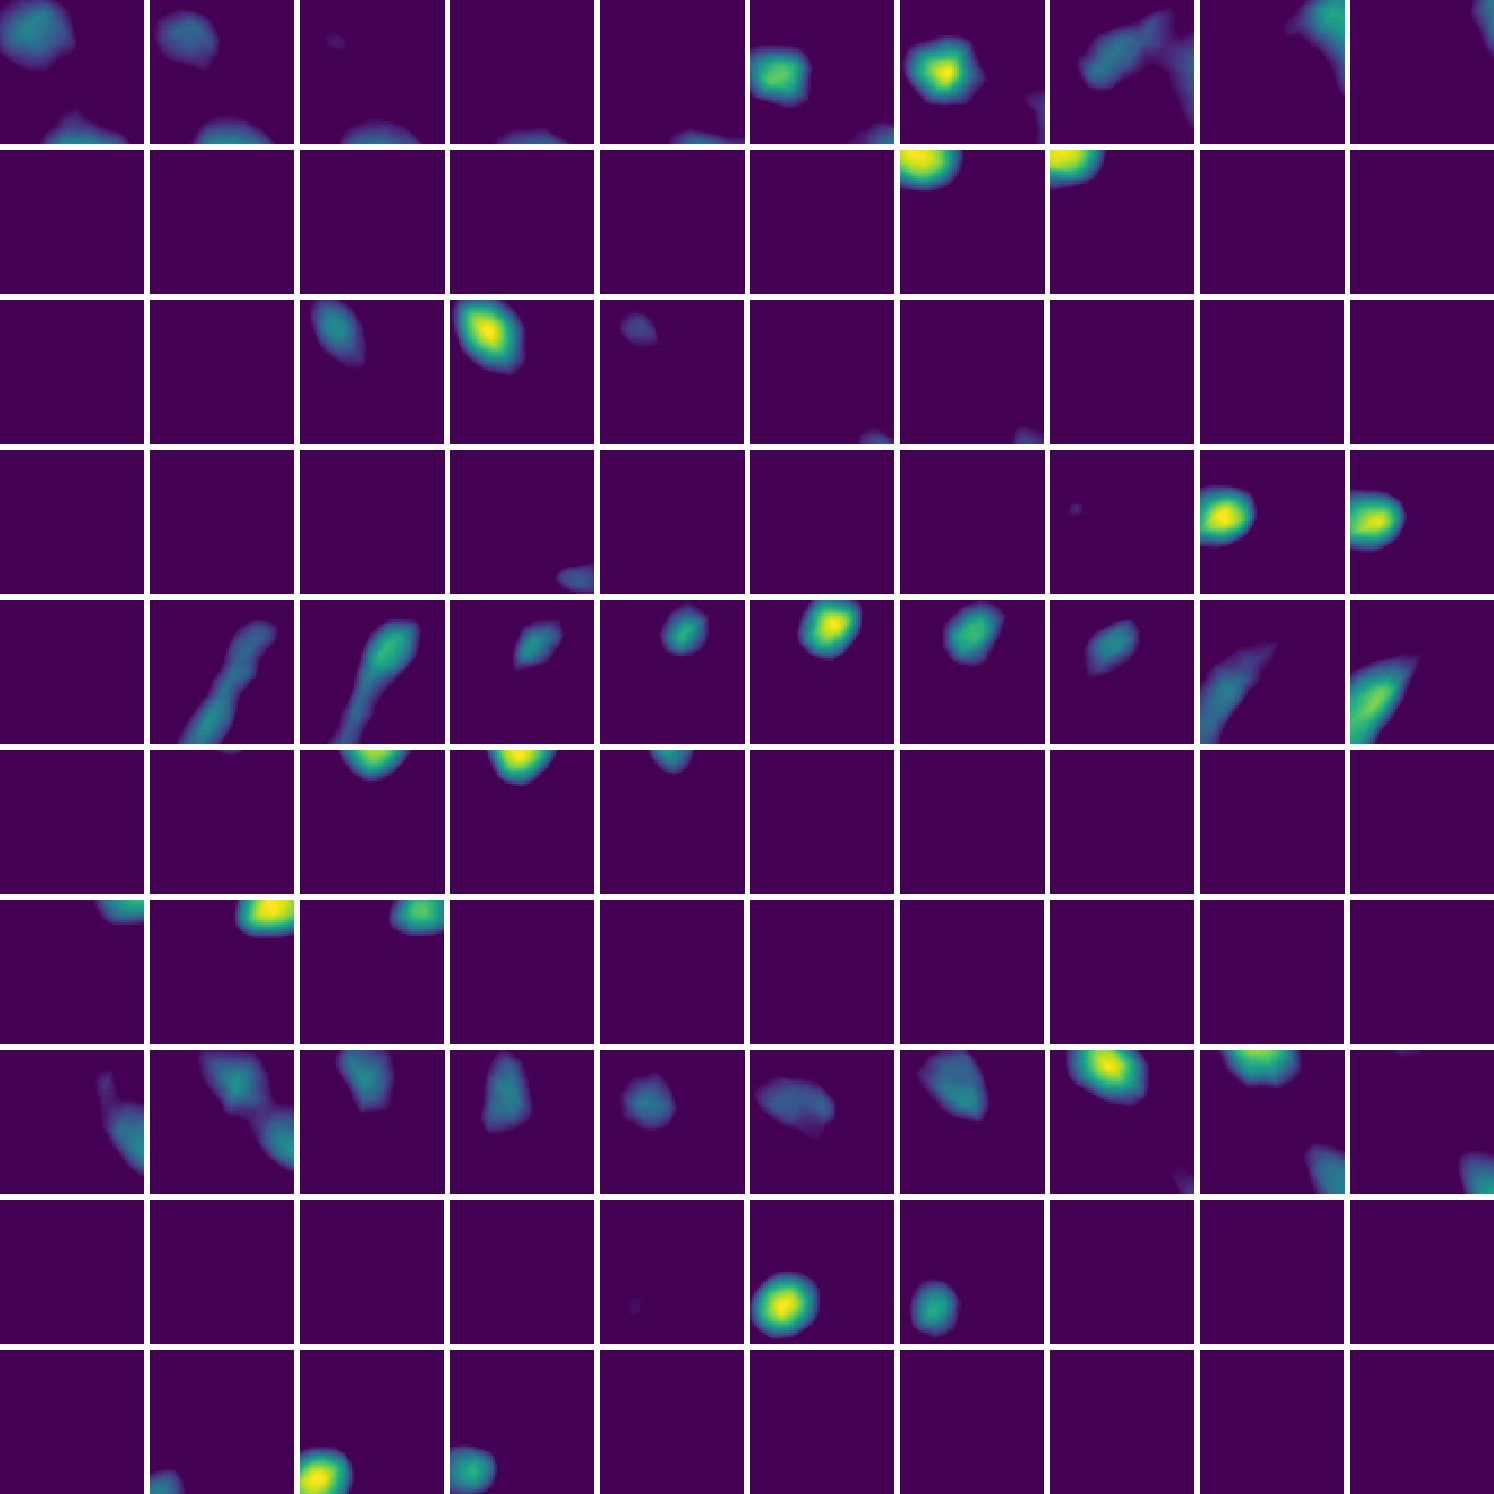

In [48]:
# Find cells that are active somewhere
active = np.max(maps, axis=(0, 2, 3)) > 0.1

fig, axs = plt.subplots(ncols=len(contexts), nrows=n_cells, figsize=(len(contexts), n_cells))
for i, n in enumerate(np.where(active)[0][:10]):
    max_val = np.max(maps[:, n])
    for j in range(len(contexts)):
        axs[i, j].imshow(maps[j, n], cmap="viridis", vmin=0, vmax=max_val)
        axs[i, j].axis("off")
plt.show()

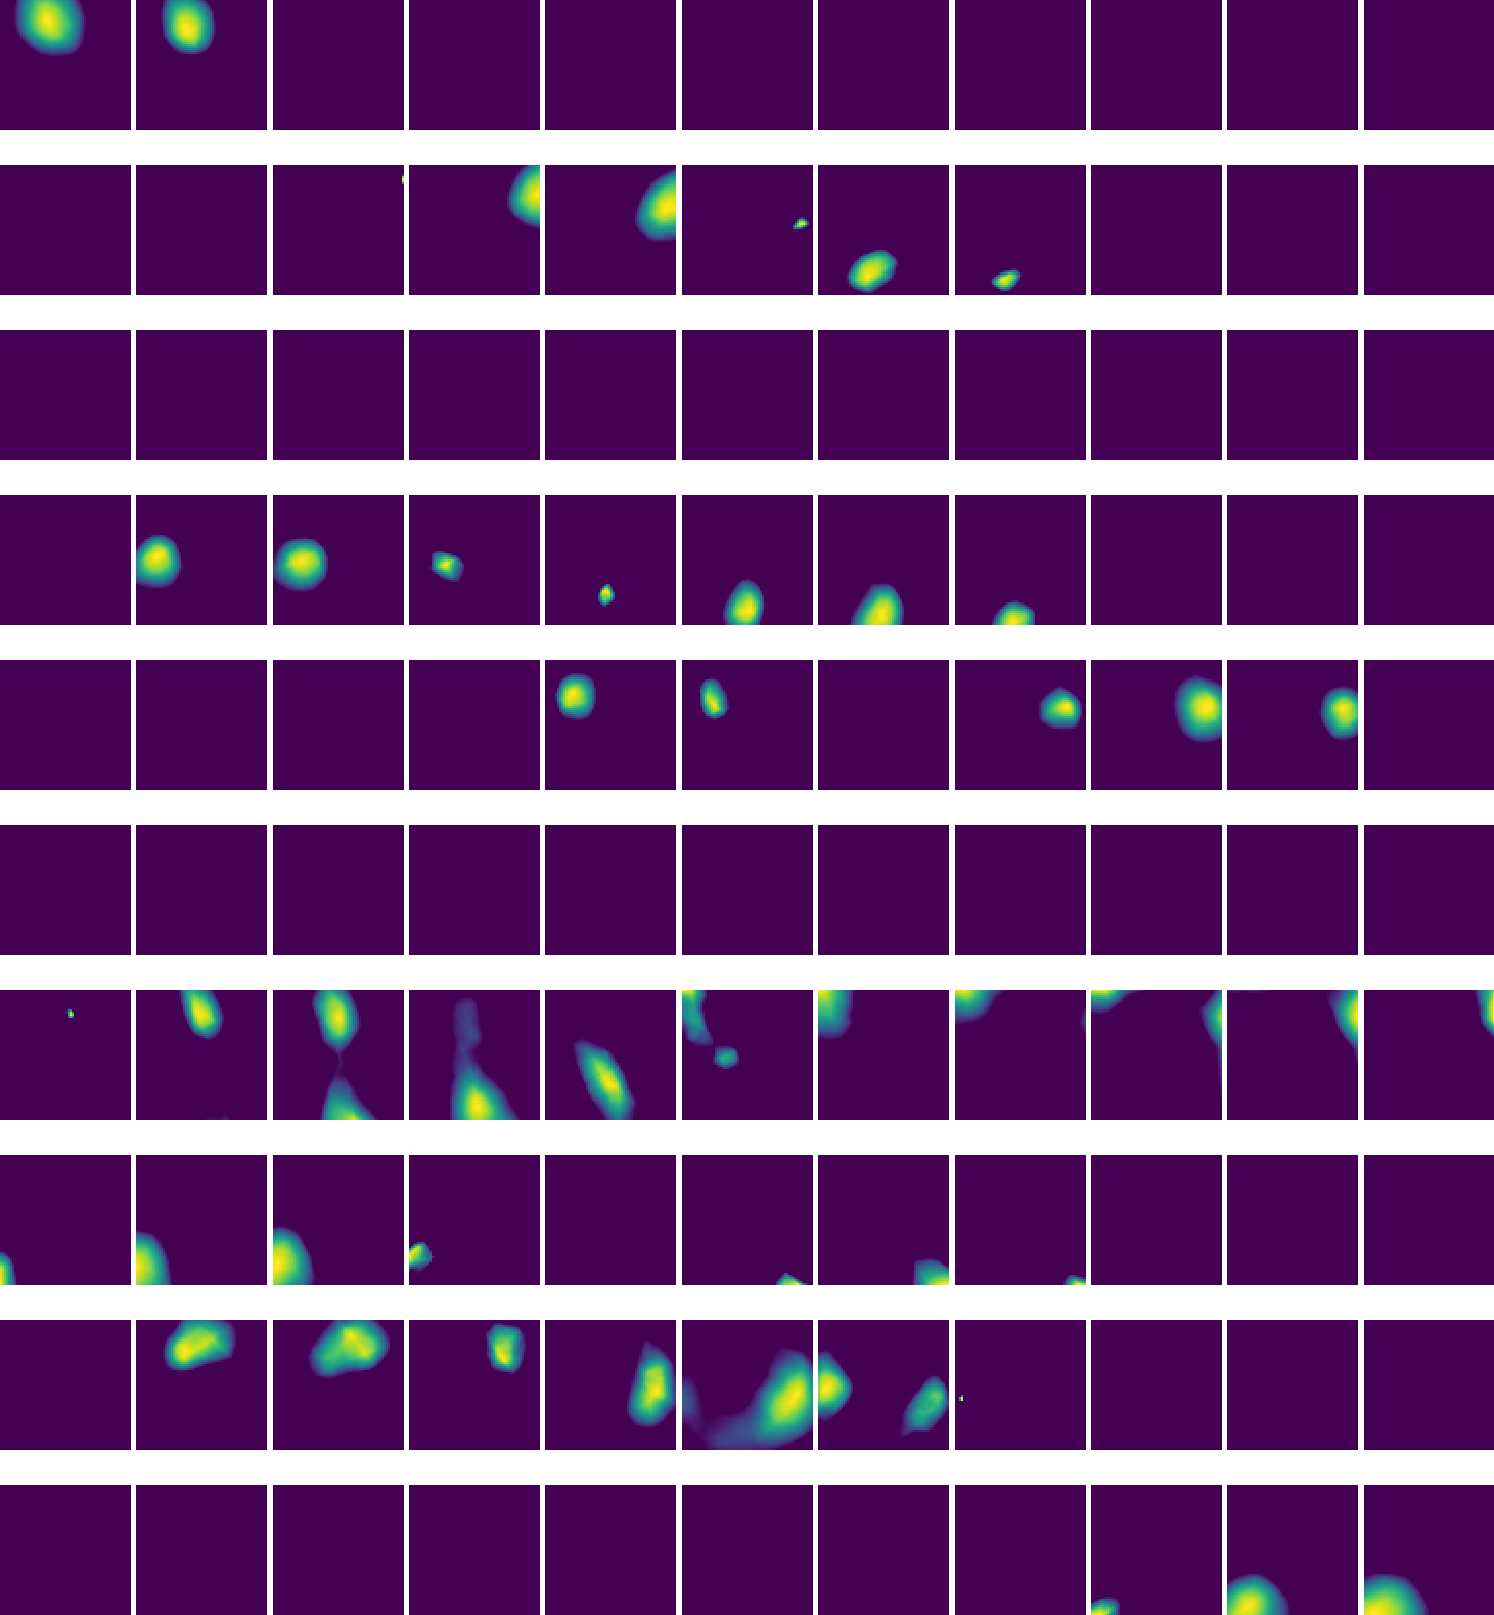

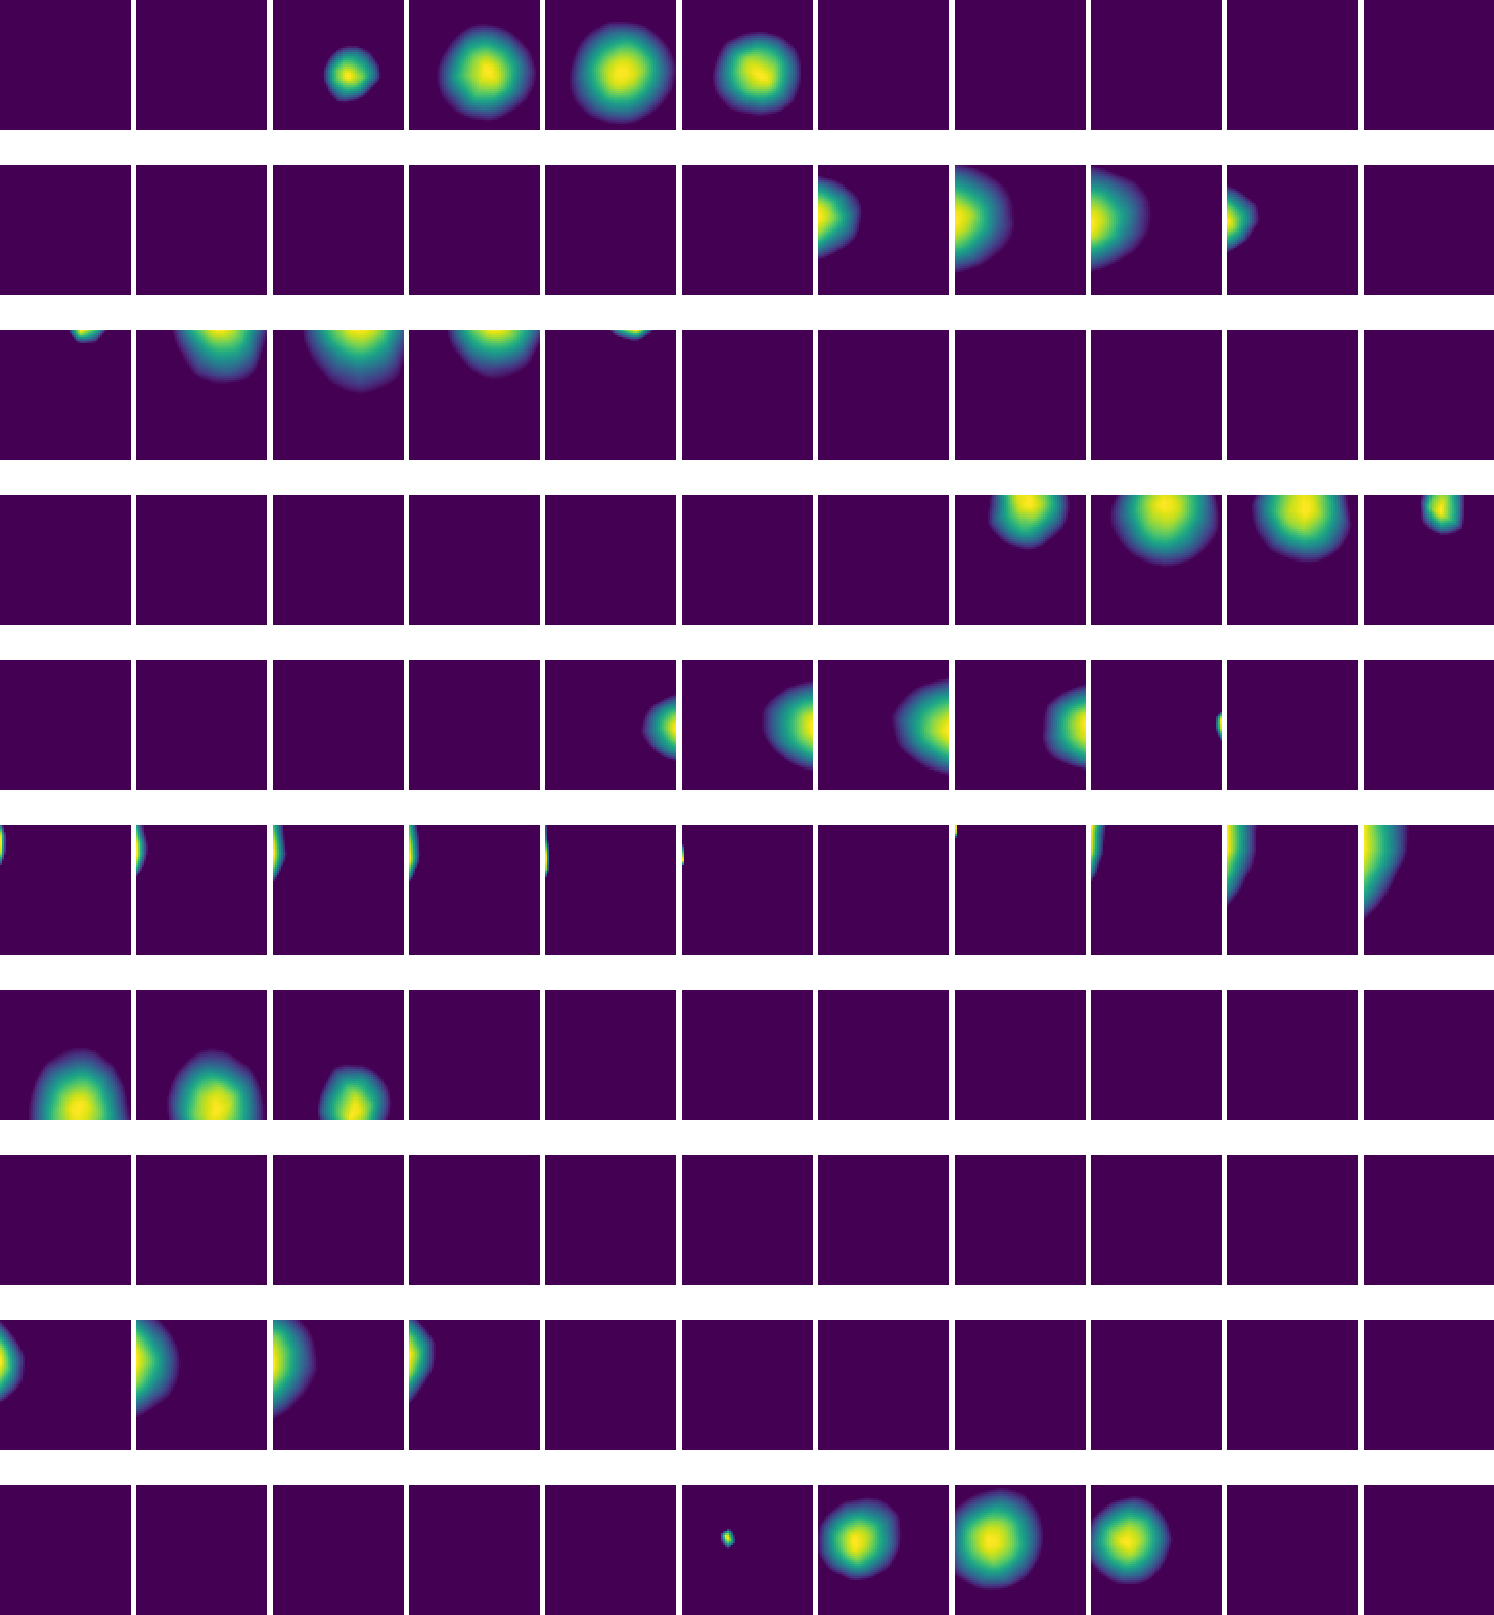

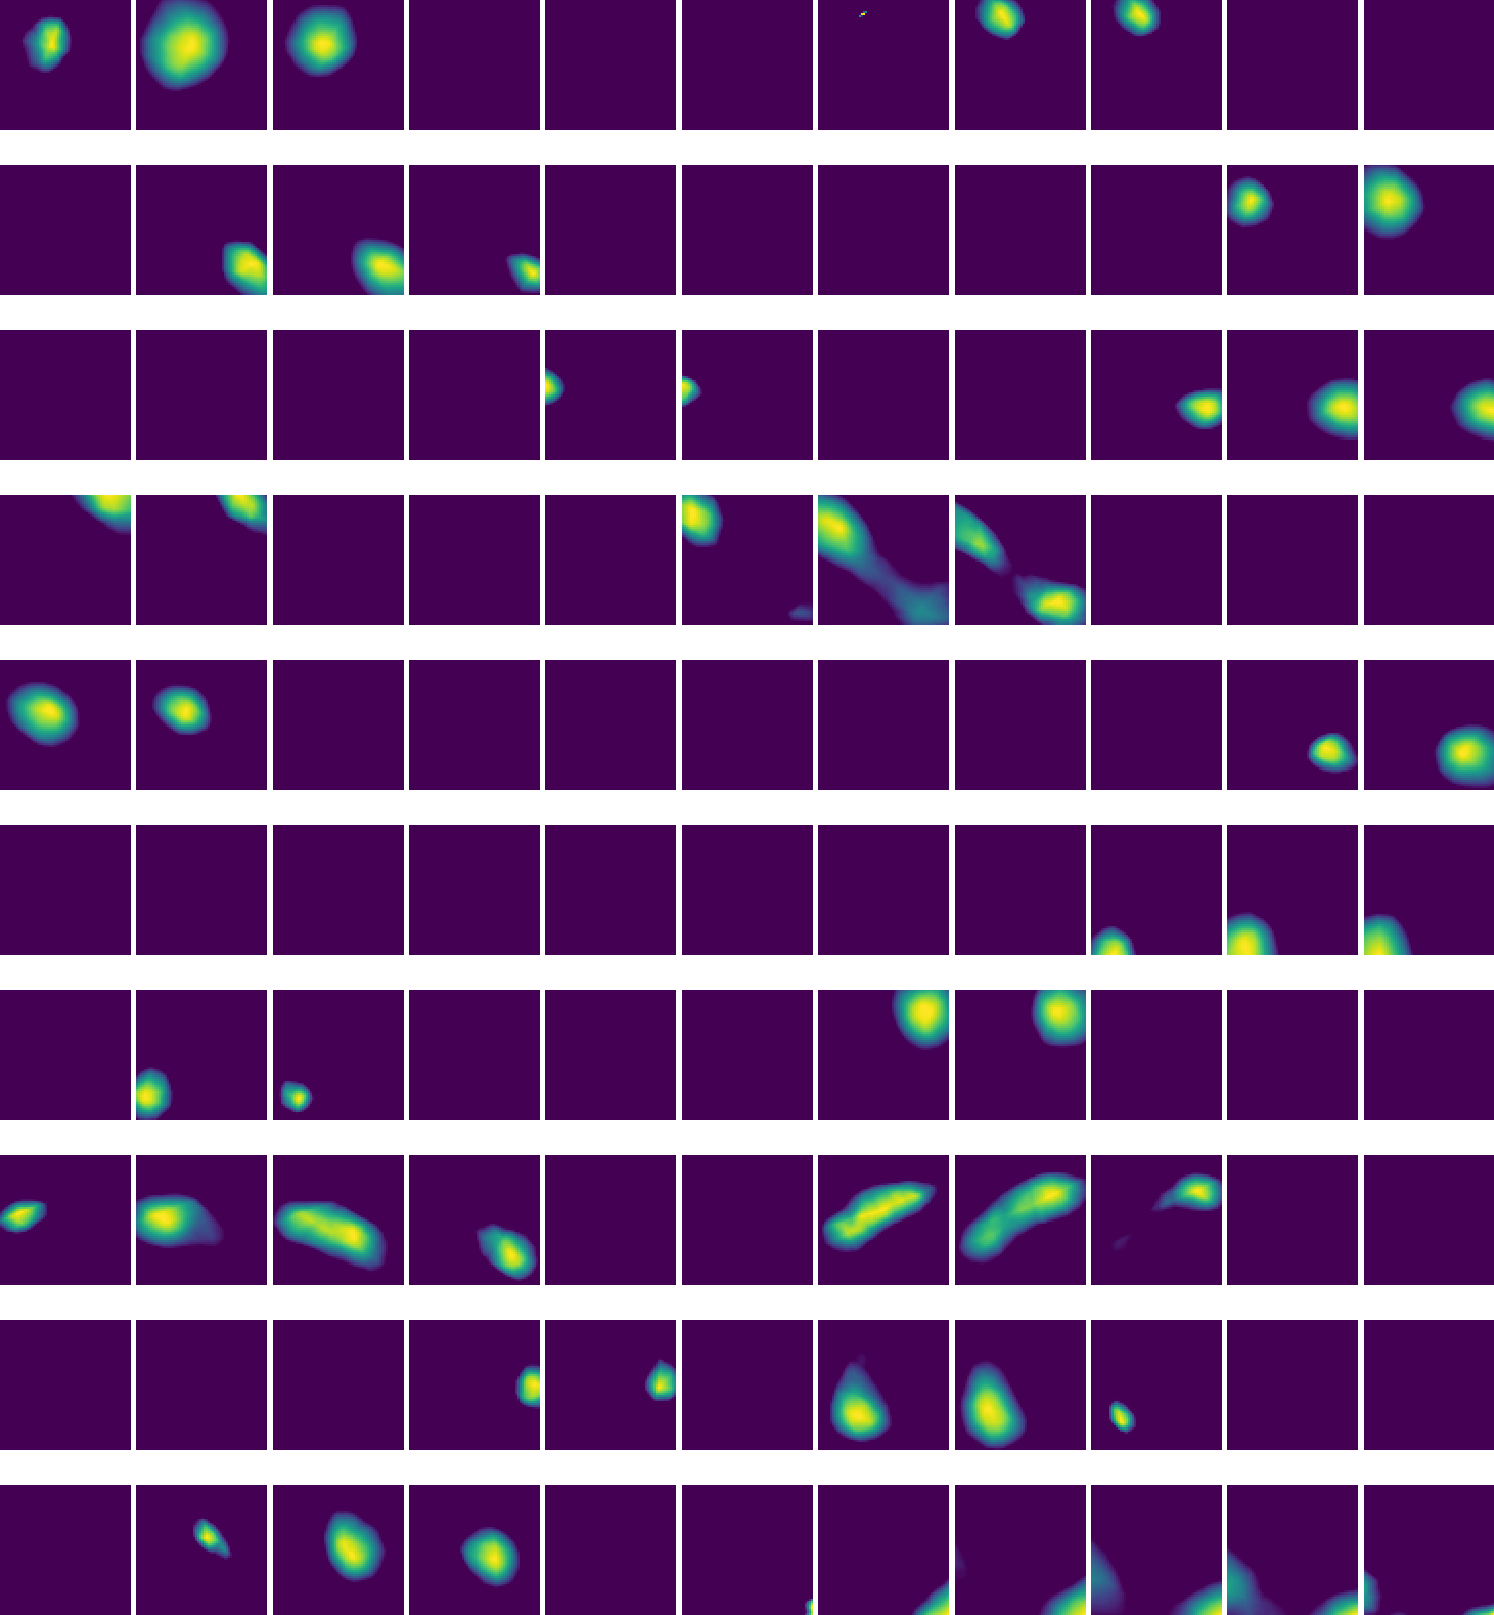

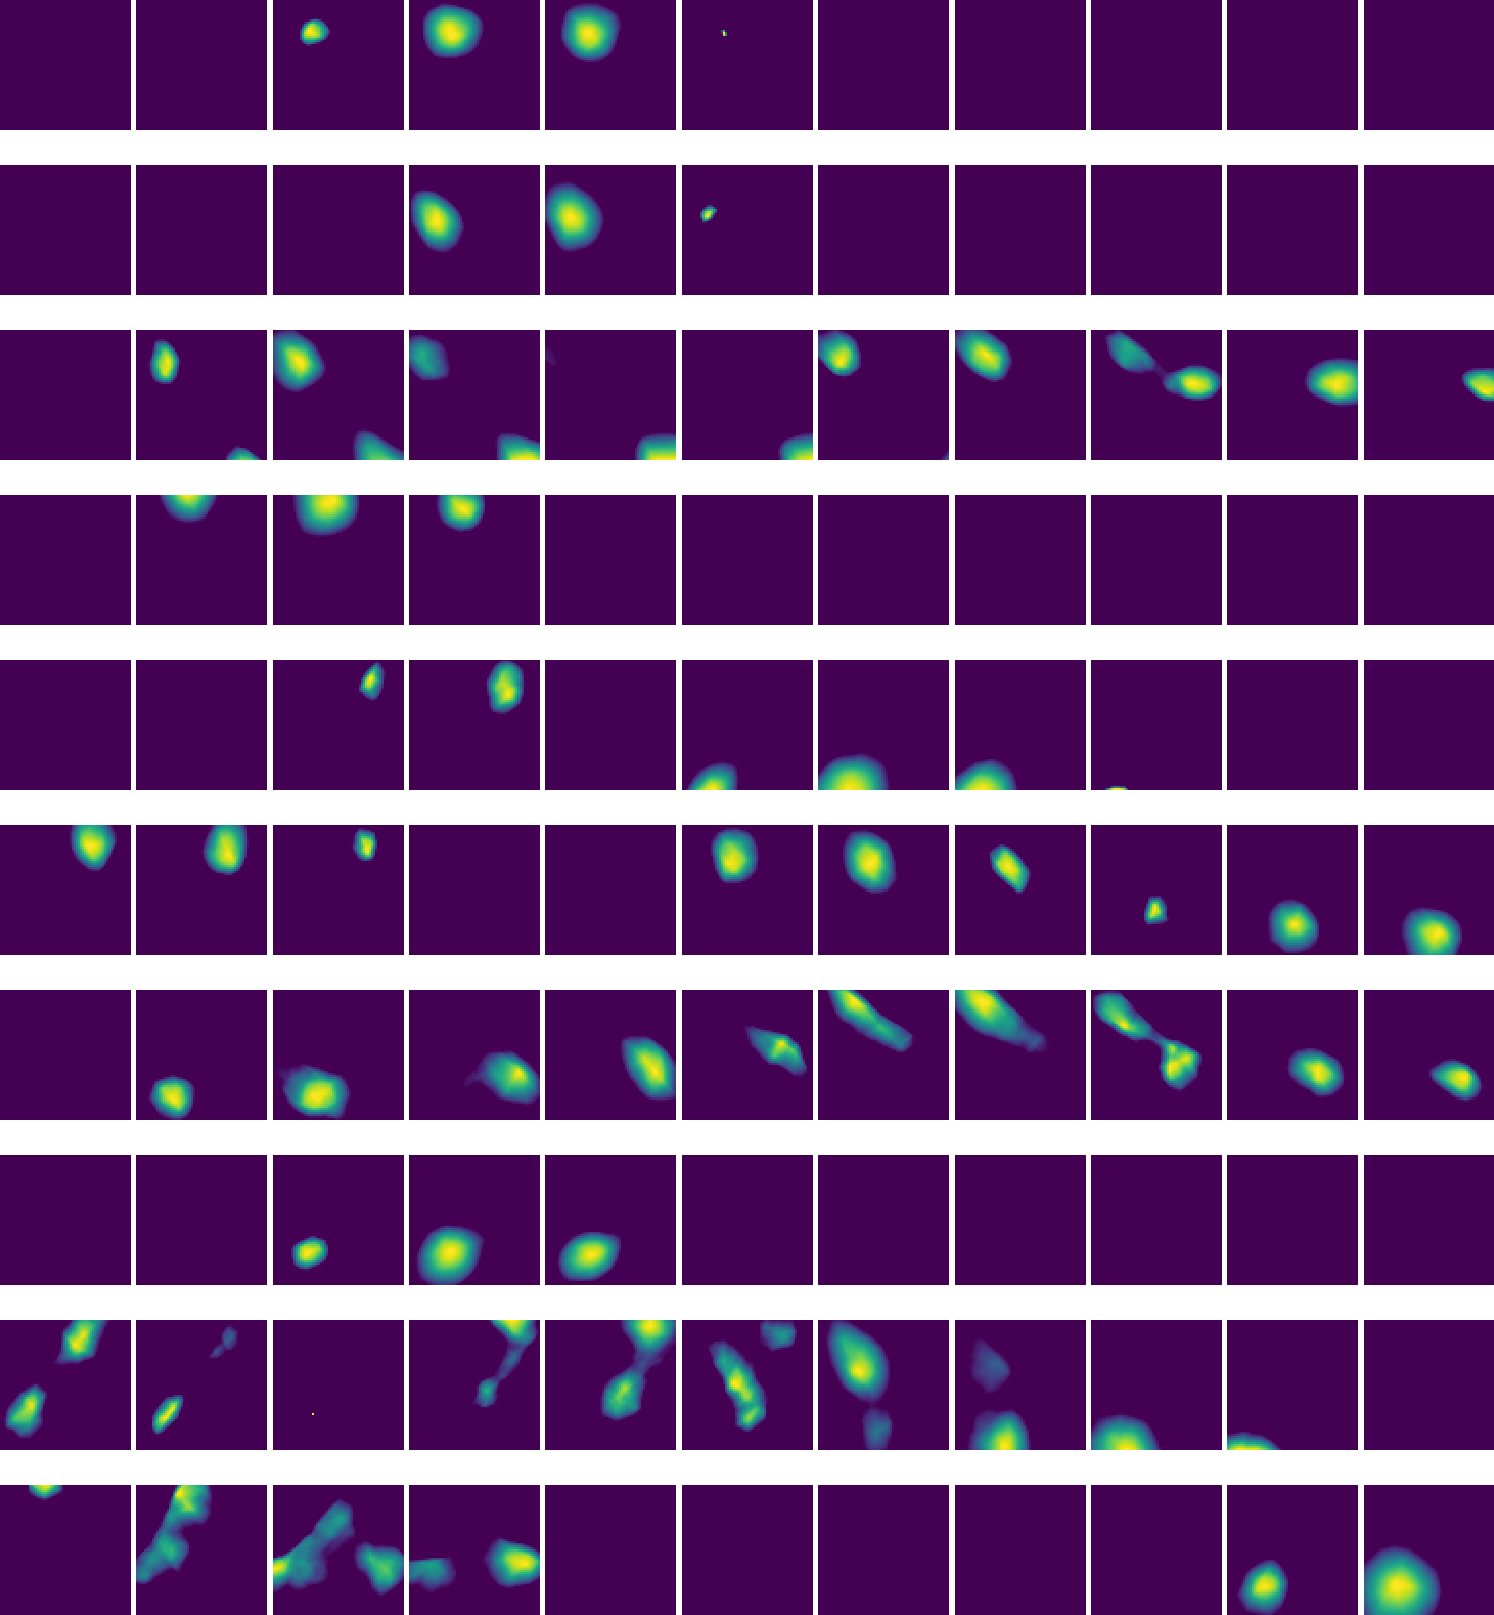

In [5]:
contexts = np.linspace(-2, 2, 11)

for model_name in [
    "256_ff_context",
    "256_ff_context_0beta",
    "256_ff_context_025beta",
    "256_ff_context_075beta"
]:

    model = torch.load(os.path.join(model_path, f"{model_name}_0.pt"))
    
    fig, axs = plt.subplots(ncols=len(contexts), nrows=10, figsize=(10, len(contexts)))
    for i in range(10):
        for j, context in enumerate(contexts):
            ratemaps = get_ratemaps(model, bins=64, context=context)
            axs[i, j].imshow(ratemaps[i], cmap="viridis")
            axs[i, j].axis("off")
        
    plt.show()
    
    fig.savefig(os.path.join(figure_path, f'{model_name}_context_maps.svg'), transparent=True)